### Basic neural activity analysis with single camera tracking
#### use GLM model to analyze spike count trains, the GLM use continuous variables and use basis kernel to simplify the fitting
#### also add the function to reduce the continuous variables into smaller dimensions to reduce the correlation and be more task related 

In [46]:
import pandas as pd
import numpy as np
from numpy import genfromtxt
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn
import scipy
import scipy.stats as st
import scipy.io
from sklearn.neighbors import KernelDensity
from sklearn.decomposition import PCA
import string
import warnings
import pickle
import json

import statsmodels.api as sm

import os
import glob
import random
from time import time

from scipy.ndimage import label


### function - get body part location for each pair of cameras

In [47]:
from ana_functions.body_part_locs_eachpair import body_part_locs_eachpair
from ana_functions.body_part_locs_singlecam import body_part_locs_singlecam

### function - align the two cameras

In [48]:
from ana_functions.camera_align import camera_align       

### function - merge the two pairs of cameras

In [49]:
from ana_functions.camera_merge import camera_merge

### function - find social gaze time point

In [50]:
from ana_functions.find_socialgaze_timepoint import find_socialgaze_timepoint
from ana_functions.find_socialgaze_timepoint_singlecam import find_socialgaze_timepoint_singlecam
from ana_functions.find_socialgaze_timepoint_singlecam_wholebody import find_socialgaze_timepoint_singlecam_wholebody

### function - define time point of behavioral events

In [51]:
from ana_functions.bhv_events_timepoint import bhv_events_timepoint
from ana_functions.bhv_events_timepoint_singlecam import bhv_events_timepoint_singlecam

### function - plot behavioral events

In [52]:
from ana_functions.plot_bhv_events import plot_bhv_events
from ana_functions.plot_bhv_events_levertube import plot_bhv_events_levertube
from ana_functions.draw_self_loop import draw_self_loop
import matplotlib.patches as mpatches 
from matplotlib.collections import PatchCollection

### function - plot inter-pull interval

In [53]:
from ana_functions.plot_interpull_interval import plot_interpull_interval

### function - interval between all behavioral events

In [54]:
from ana_functions.bhv_events_interval import bhv_events_interval

### function - GLM fitting for spike trains based on the discrete variables from single camera

In [55]:
from ana_functions.singlecam_bhv_var_neuralGLM_fitting_BasisKernelsForContVaris import get_singlecam_bhv_var_for_neuralGLM_fitting_BasisKernelsForContVaris
from ana_functions.singlecam_bhv_var_neuralGLM_fitting_BasisKernelsForContVaris import neuralGLM_fitting_BasisKernelsForContVaris

from ana_functions.singlecam_bhv_var_neuralGLM_fitting_BasisKernelsForContVaris_PullGazeVectorProjection \
import neuralGLM_fitting_BasisKernelsForContVaris_PullGazeVectorProjection

from ana_functions.singlecam_bhv_var_neuralGLM_fitting_BasisKernelsForContVaris_PullGazeVectorProjection \
import neuralGLM_fitting_BasisKernelsForContVaris_PullGazeVectorProjection_partnerPC1

from ana_functions.singlecam_bhv_var_neuralGLM_fitting_BasisKernelsForContVaris_PullGazeVectorProjection \
import neuralGLM_fitting_BasisKernelsForContVaris_PullGazeAxis_partnerPC1

from ana_functions.singlecam_bhv_var_neuralGLM_fitting_BasisKernelsForContVaris_PullGazeVectorProjection \
import neuralGLM_fitting_BasisKernelsForContVaris_PullGazeAxis_partnerPullGazeAxis

from ana_functions.singlecam_bhv_var_neuralGLM_fitting_BasisKernelsForContVaris_PullGazeVectorProjection \
import neuralGLM_fitting_BasisKernelsForContVaris_PullGazeAxis_partnerPC1_LOOmethods


### function - other useful functions

In [56]:
# for defining the meaningful social gaze (the continuous gaze distribution that is closest to the pull) 
from ana_functions.keep_closest_cluster_single_trial import keep_closest_cluster_single_trial

In [57]:
# get useful information about pulls
from ana_functions.get_pull_infos import get_pull_infos

In [58]:
# use the gaze vector speed and face mass speed to find the pull action start time within IPI
from ana_functions.find_sharp_increases_withinIPI import find_sharp_increases_withinIPI
from ana_functions.find_sharp_increases_withinIPI import find_sharp_increases_withinIPI_dual_speed

In [59]:
def cluster_based_correction_with_timing(real_mean, shuffled_coefs, alpha_form, alpha_sig, time_axis=None):
    n_boot, n_vars, n_basis = shuffled_coefs.shape
    cluster_significance = np.zeros(n_vars, dtype=bool)
    cluster_timing = ['None'] * n_vars

    for var in range(n_vars):
        real_coef = real_mean[var, :]
        shuf_coef = shuffled_coefs[:, var, :]

        # Empirical p-values
        p_vals = (np.sum(np.abs(shuf_coef) >= np.abs(real_coef), axis=0) + 1) / (n_boot + 1)
        sig_mask = p_vals < alpha_form

        # Cluster label
        labeled_array, n_clusters = label(sig_mask)
        real_cluster_sizes = [
            np.sum(labeled_array == cluster_idx + 1)
            for cluster_idx in range(n_clusters)
        ]
        max_real_cluster = np.max(real_cluster_sizes) if real_cluster_sizes else 0

        # Compute max cluster size in each shuffled iteration
        shuf_max_clusters = []
        for b in range(n_boot):
            others = np.delete(shuf_coef, b, axis=0)
            p_vals_shuf = np.mean(np.abs(others) >= np.abs(shuf_coef[b, :]), axis=0)
            sig_shuf = p_vals_shuf < alpha_form
            lbl_shuf, n_lbl = label(sig_shuf)
            max_cluster = max([np.sum(lbl_shuf == i + 1) for i in range(n_lbl)], default=0)
            shuf_max_clusters.append(max_cluster)

        cluster_thresh = np.percentile(shuf_max_clusters, 100 * (1 - alpha_sig))
        cluster_significance[var] = max_real_cluster > cluster_thresh

        # Dominant timing classification
        if cluster_significance[var] and time_axis is not None:
            sig_times = time_axis[sig_mask]
            n_before = np.sum(sig_times < 0)
            n_after = np.sum(sig_times > 0)

            if n_before > n_after:
                cluster_timing[var] = 'Reactive'
            elif n_after > n_before:
                cluster_timing[var] = 'Predictive'
            else:
                cluster_timing[var] = 'Both' if (n_before > 0) else 'None'

    return cluster_significance, cluster_timing

In [60]:
# check the orthogonality among the three behavioral vectors
def check_orthogonality(*vectors, tol=1e-6):
    n = len(vectors)
    for i in range(n):
        for j in range(i + 1, n):
            dot = np.dot(vectors[i], vectors[j])
            print(f"Dot product between vector {i} and {j}: {dot:.6f}")
            if abs(dot) > tol:
                print("⚠️ Not orthogonal!")
            else:
                print("✅ Orthogonal")
                
#  Gram-Schmidt Orthogonalization
def gram_schmidt(vectors):
    """Orthogonalize a list of vectors using the Gram-Schmidt process."""
    orthogonal_vectors = []
    for v in vectors:
        # Subtract projection onto all previous orthogonal vectors
        for u in orthogonal_vectors:
            v = v - np.dot(v, u) * u
        # Normalize the vector
        norm = np.linalg.norm(v)
        if norm > 1e-10:
            orthogonal_vectors.append(v / norm)
    return orthogonal_vectors

## Analyze each session

### prepare the basic behavioral data (especially the time stamps for each bhv events)

In [167]:
# instead of using gaze angle threshold, use the target rectagon to deside gaze info
# ...need to update
sqr_thres_tubelever = 75 # draw the square around tube and lever
sqr_thres_face = 1.15 # a ratio for defining face boundary
sqr_thres_body = 4 # how many times to enlongate the face box boundry to the body


# get the fps of the analyzed video
fps = 30

# get the fs for neural recording
fs_spikes = 20000
fs_lfp = 1000

# frame number of the demo video
# nframes = 0.5*30 # second*30fps
nframes = 45*30 # second*30fps

# re-analyze the video or not
reanalyze_video = 0
redo_anystep = 0

# do OFC sessions or DLPFC sessions
do_OFC = 0
do_DLPFC  = 1
if do_OFC:
    savefile_sufix = '_OFCs'
elif do_DLPFC:
    savefile_sufix = '_DLPFCs'
else:
    savefile_sufix = ''
    
    
# glm types
# glm_encoding_type = 'withpartnerPC1_' # '', 'withpartnerPC1_',  'pullgazeAxis_partnerPC1_', 'orinigalV1to8_'(do not use)
glm_encoding_type = 'pullgazeAxis_partnerPC1_' # '', 'withpartnerPC1_',  'pullgazeAxis_partnerPC1_', 'orinigalV1to8_'(do not use)
# glm_encoding_type = '' # empty means ucs the projected 'PCs' to the pull and gaze axis, but did not consider partnerPC1
    
# all the videos (no misaligned ones)
# aligned with the audio
# get the session start time from "videosound_bhv_sync.py/.ipynb"
# currently the session_start_time will be manually typed in. It can be updated after a better method is used

# dodson ginger
if 1:
    if do_DLPFC:
        neural_record_conditions = [
                                    '20240531_Dodson_MC',
                                    '20240603_Dodson_MC_and_SR',
                                    '20240603_Dodson_MC_and_SR',
                                    '20240604_Dodson_MC',
                                    '20240605_Dodson_MC_and_SR',
                                    '20240605_Dodson_MC_and_SR',
                                    '20240606_Dodson_MC_and_SR',
                                    '20240606_Dodson_MC_and_SR',
                                    '20240607_Dodson_SR',
                                    '20240610_Dodson_MC',
                                    '20240611_Dodson_SR',
                                    '20240612_Dodson_MC',
                                    '20240613_Dodson_SR',
                                    '20240620_Dodson_SR',
                                    '20240719_Dodson_MC',
                                        
                                    '20250129_Dodson_MC',
                                    '20250130_Dodson_SR',
                                    '20250131_Dodson_MC',
                                
            
                                    '20250210_Dodson_SR_withKoala',
                                    '20250211_Dodson_MC_withKoala',
                                    '20250212_Dodson_SR_withKoala',
                                    '20250214_Dodson_MC_withKoala',
                                    '20250217_Dodson_SR_withKoala',
                                    '20250218_Dodson_MC_withKoala',
                                    '20250219_Dodson_SR_withKoala',
                                    '20250220_Dodson_MC_withKoala',
                                    '20250224_Dodson_KoalaAL_withKoala',
                                    '20250226_Dodson_MC_withKoala',
                                    '20250227_Dodson_KoalaAL_withKoala',
                                    '20250228_Dodson_DodsonAL_withKoala',
                                    '20250304_Dodson_DodsonAL_withKoala',
                                    '20250305_Dodson_MC_withKoala',
                                    '20250306_Dodson_KoalaAL_withKoala',
                                    '20250307_Dodson_DodsonAL_withKoala',
                                    '20250310_Dodson_MC_withKoala',
                                    '20250312_Dodson_NV_withKoala',
                                    '20250313_Dodson_NV_withKoala',
                                    '20250314_Dodson_NV_withKoala',
            
                                    '20250401_Dodson_MC_withKanga',
                                    '20250402_Dodson_MC_withKanga',
                                    '20250403_Dodson_MC_withKanga',
                                    '20250404_Dodson_SR_withKanga',
                                    '20250407_Dodson_SR_withKanga',
                                    '20250408_Dodson_SR_withKanga',
                                    '20250409_Dodson_MC_withKanga',
            
                                    '20250415_Dodson_MC_withKanga',
                                    # '20250416_Dodson_SR_withKanga', # has to remove from the later analysis, recording has problems
                                    '20250417_Dodson_MC_withKanga',
                                    '20250418_Dodson_SR_withKanga',
                                    '20250421_Dodson_SR_withKanga',
                                    '20250422_Dodson_MC_withKanga',
                                    '20250422_Dodson_SR_withKanga',
            
                                    '20250423_Dodson_MC_withKanga',
                                    '20250423_Dodson_SR_withKanga', 
                                    '20250424_Dodson_NV_withKanga',
                                    '20250424_Dodson_MC_withKanga',
                                    '20250424_Dodson_SR_withKanga',            
                                    '20250425_Dodson_NV_withKanga',
                                    '20250425_Dodson_SR_withKanga',
                                    '20250428_Dodson_NV_withKanga',
                                    '20250428_Dodson_MC_withKanga',
                                    '20250428_Dodson_SR_withKanga',  
                                    '20250429_Dodson_NV_withKanga',
                                    '20250429_Dodson_MC_withKanga',
                                    '20250429_Dodson_SR_withKanga',  
                                    '20250430_Dodson_NV_withKanga',
                                    '20250430_Dodson_MC_withKanga',
                                    '20250430_Dodson_SR_withKanga',  
            
                                   ]
        task_conditions = [
                            'MC',           
                            'MC',
                            'SR',
                            'MC',
                            'MC',
                            'SR',
                            'MC',
                            'SR',
                            'SR',
                            'MC',
                            'SR',
                            'MC',
                            'SR',
                            'SR',
                            'MC',
                            
                            'MC_withGingerNew',
                            'SR_withGingerNew',
                            'MC_withGingerNew',
            
                            'SR_withKoala',
                            'MC_withKoala',
                            'SR_withKoala',
                            'MC_withKoala',
                            'SR_withKoala',
                            'MC_withKoala',
                            'SR_withKoala',
                            'MC_withKoala',
                            'MC_KoalaAuto_withKoala',
                            'MC_withKoala',
                            'MC_KoalaAuto_withKoala',
                            'MC_DodsonAuto_withKoala',
                            'MC_DodsonAuto_withKoala',
                            'MC_withKoala',
                            'MC_KoalaAuto_withKoala',
                            'MC_DodsonAuto_withKoala',
                            'MC_withKoala',
                            'NV_withKoala',
                            'NV_withKoala',
                            'NV_withKoala',

                            'MC_withKanga',
                            'MC_withKanga',
                            'MC_withKanga',
                            'SR_withKanga',
                            'SR_withKanga',
                            'SR_withKanga',
                            'MC_withKanga',
            
                            'MC_withKanga',
                            # 'SR_withKanga',
                            'MC_withKanga',
                            'SR_withKanga',
                            'SR_withKanga',
                            'MC_withKanga',
                            'SR_withKanga',
            
                            'MC_withKanga',
                            'SR_withKanga', 
                            'NV_withKanga',
                            'MC_withKanga',
                            'SR_withKanga',            
                            'NV_withKanga',
                            'SR_withKanga',
                            'NV_withKanga',
                            'MC_withKanga',
                            'SR_withKanga',  
                            'NV_withKanga',
                            'MC_withKanga',
                            'SR_withKanga',  
                            'NV_withKanga',
                            'MC_withKanga',
                            'SR_withKanga',  
                          ]
        dates_list = [
                        '20240531',
                        '20240603_MC',
                        '20240603_SR',
                        '20240604',
                        '20240605_MC',
                        '20240605_SR',
                        '20240606_MC',
                        '20240606_SR',
                        '20240607',
                        '20240610_MC',
                        '20240611',
                        '20240612',
                        '20240613',
                        '20240620',
                        '20240719',
            
                        '20250129',
                        '20250130',
                        '20250131',
            
                        '20250210',
                        '20250211',
                        '20250212',
                        '20250214',
                        '20250217',
                        '20250218',
                        '20250219',
                        '20250220',
                        '20250224',
                        '20250226',
                        '20250227',
                        '20250228',
                        '20250304',
                        '20250305',
                        '20250306',
                        '20250307',
                        '20250310',
                        '20250312',
                        '20250313',
                        '20250314',
            
                        '20250401',
                        '20250402',
                        '20250403',
                        '20250404',
                        '20250407',
                        '20250408',
                        '20250409',
            
                        '20250415',
                        # '20250416',
                        '20250417',
                        '20250418',
                        '20250421',
                        '20250422',
                        '20250422_SR',
            
                        '20250423',
                        '20250423_SR', 
                        '20250424',
                        '20250424_MC',
                        '20250424_SR',            
                        '20250425',
                        '20250425_SR',
                        '20250428_NV',
                        '20250428_MC',
                        '20250428_SR',  
                        '20250429_NV',
                        '20250429_MC',
                        '20250429_SR',  
                        '20250430_NV',
                        '20250430_MC',
                        '20250430_SR',  
                     ]
        videodates_list = [
                            '20240531',
                            '20240603',
                            '20240603',
                            '20240604',
                            '20240605',
                            '20240605',
                            '20240606',
                            '20240606',
                            '20240607',
                            '20240610_MC',
                            '20240611',
                            '20240612',
                            '20240613',
                            '20240620',
                            '20240719',
            
                            '20250129',
                            '20250130',
                            '20250131',
                            
                            '20250210',
                            '20250211',
                            '20250212',
                            '20250214',
                            '20250217',
                            '20250218',          
                            '20250219',
                            '20250220',
                            '20250224',
                            '20250226',
                            '20250227',
                            '20250228',
                            '20250304',
                            '20250305',
                            '20250306',
                            '20250307',
                            '20250310',
                            '20250312',
                            '20250313',
                            '20250314',
            
                            '20250401',
                            '20250402',
                            '20250403',
                            '20250404',
                            '20250407',
                            '20250408',
                            '20250409',
            
                            '20250415',
                            # '20250416',
                            '20250417',
                            '20250418',
                            '20250421',
                            '20250422',
                            '20250422_SR',
            
                            '20250423',
                            '20250423_SR', 
                            '20250424',
                            '20250424_MC',
                            '20250424_SR',            
                            '20250425',
                            '20250425_SR',
                            '20250428_NV',
                            '20250428_MC',
                            '20250428_SR',  
                            '20250429_NV',
                            '20250429_MC',
                            '20250429_SR',  
                            '20250430_NV',
                            '20250430_MC',
                            '20250430_SR',  
            
                          ] # to deal with the sessions that MC and SR were in the same session
        session_start_times = [ 
                                0.00,
                                340,
                                340,
                                72.0,
                                60.1,
                                60.1,
                                82.2,
                                82.2,
                                35.8,
                                0.00,
                                29.2,
                                35.8,
                                62.5,
                                71.5,
                                54.4,
            
                                0.00,
                                0.00,
                                0.00,
            
                                0.00,
                                0.00,
                                0.00,
                                0.00,
                                0.00,
                                0.00,
                                0.00,
                                0.00,
                                0.00,
                                0.00,
                                0.00,
                                0.00,
                                0.00,
                                0.00,
                                0.00,
                                0.00,
                                0.00,
                                0.00,
                                0.00,
                                0.00,
            
                                0.00,
                                0.00,
                                73.5,
                                0.00,
                                76.1,
                                81.5,
                                0.00,
            
                                363,
                                # 0.00,
                                79.0,
                                162.6,
                                231.9,
                                109,
                                0.00,
            
                                0.00,
                                0.00, 
                                0.00,
                                0.00,
                                0.00,          
                                0.00,
                                93.0,
                                0.00,
                                0.00,
                                0.00,
                                0.00,
                                0.00,
                                0.00, 
                                0.00,
                                274.4,
                                0.00,
            
                              ] # in second
        
        kilosortvers = list((np.ones(np.shape(dates_list))*4).astype(int))
        
        trig_channelnames = [ 'Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0',
                              'Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0',
                              'Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0',
                              'Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0',
                              'Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0',
                              'Dev1/ai0',# 'Dev1/ai0',
                              'Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai9','Dev1/ai9','Dev1/ai9','Dev1/ai9',
                              'Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0',
                              'Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0',
                             
                              ]
        animal1_fixedorders = ['dodson','dodson','dodson','dodson','dodson','dodson','dodson','dodson','dodson',
                               'dodson','dodson','dodson','dodson','dodson','dodson','dodson','dodson','dodson',
                               'dodson','dodson','dodson','dodson','dodson','dodson','dodson','dodson','dodson',
                               'dodson','dodson','dodson','dodson','dodson','dodson','dodson','dodson','dodson',
                               'dodson','dodson','dodson','dodson','dodson','dodson','dodson','dodson','dodson',
                               'dodson',# 'dodson',
                               'dodson','dodson','dodson','dodson','dodson','dodson','dodson',
                               'dodson','dodson','dodson','dodson','dodson','dodson','dodson','dodson','dodson',
                               'dodson','dodson','dodson','dodson','dodson',
                              ]
        recordedanimals = animal1_fixedorders 
        animal2_fixedorders = ['ginger','ginger','ginger','ginger','ginger','ginger','ginger','ginger','ginger',
                               'ginger','ginger','ginger','ginger','ginger','ginger','gingerNew','gingerNew','gingerNew',
                               'koala', 'koala', 'koala', 'koala', 'koala', 'koala', 'koala', 'koala', 'koala',
                               'koala', 'koala', 'koala', 'koala', 'koala', 'koala', 'koala', 'koala', 'koala',
                               'koala', 'koala', 'kanga', 'kanga', 'kanga', 'kanga', 'kanga', 'kanga', 'kanga',
                               'kanga', # 'kanga', 
                               'kanga', 'kanga', 'kanga', 'kanga', 'kanga', 'kanga', 'kanga',
                               'kanga', 'kanga', 'kanga', 'kanga', 'kanga', 'kanga', 'kanga', 'kanga', 'kanga',
                               'kanga', 'kanga', 'kanga', 'kanga', 'kanga',
                              ]

        animal1_filenames = ["Dodson","Dodson","Dodson","Dodson","Dodson","Dodson","Dodson","Dodson","Dodson",
                             "Dodson","Dodson","Dodson","Dodson","Dodson","Dodson","Dodson","Dodson","Dodson",
                             "Dodson","Dodson","Dodson","Dodson","Dodson","Dodson","Dodson","Dodson","Dodson",
                             "Dodson","Dodson","Dodson","Dodson","Dodson","Dodson","Dodson","Dodson","Dodson",
                             "Dodson","Dodson","Dodson","Dodson","Dodson","Dodson","Dodson","Dodson","Dodson",
                             'Dodson',# 'Dodson',
                             'Dodson','Dodson','Dodson','Dodson','Dodson','Dodson','Dodson',
                             'Dodson','Dodson','Dodson','Dodson','Dodson','Dodson','Dodson','Dodson','Dodson',
                             'Dodson','Dodson','Dodson','Dodson','Dodson',
                            ]
        animal2_filenames = ["Ginger","Ginger","Ginger","Ginger","Ginger","Ginger","Ginger","Ginger","Ginger",
                             "Ginger","Ginger","Ginger","Ginger","Ginger","Ginger","Ginger","Ginger","Ginger",
                             "Koala", "Koala", "Koala", "Koala", "Koala", "Koala", "Koala", "Koala", "Koala",
                             "Koala", "Koala", "Koala", "Koala", "Koala", "Koala", "Koala", "Koala", "Koala",
                             "Koala", "Koala", "Kanga", "Kanga", "Kanga", "Kanga", "Kanga", "Kanga", "Kanga",
                             'Kanga', # 'Kanga', 
                             'Kanga', 'Kanga', 'Kanga', 'Kanga', 'Kanga', 'Kanga', 'Kanga',
                             'Kanga', 'Kanga', 'Kanga', 'Kanga', 'Kanga', 'Kanga', 'Kanga', 'Kanga', 'Kanga',
                             'Kanga', 'Kanga', 'Kanga', 'Kanga', 'Kanga',
                            ]
        
    elif do_OFC:
        # pick only five sessions for each conditions
        neural_record_conditions = [
                                     '20231101_Dodson_withGinger_MC',
                                     '20231107_Dodson_withGinger_MC',
                                     '20231122_Dodson_withGinger_MC',
                                     '20231129_Dodson_withGinger_MC',
                                     '20231101_Dodson_withGinger_SR',
                                     '20231107_Dodson_withGinger_SR',
                                     '20231122_Dodson_withGinger_SR',
                                     '20231129_Dodson_withGinger_SR',
                                   ]
        task_conditions = [
                            'MC',
                            'MC',
                            'MC',
                            'MC',
                            'SR',
                            'SR',
                            'SR',
                            'SR',
                          ]
        dates_list = [
                      "20231101_MC",
                      "20231107_MC",
                      "20231122_MC",
                      "20231129_MC",
                      "20231101_SR",
                      "20231107_SR",
                      "20231122_SR",
                      "20231129_SR",      
                     ]
        videodates_list = dates_list
        session_start_times = [ 
                                 0.00,   
                                 0.00,  
                                 0.00,  
                                 0.00, 
                                 0.00,   
                                 0.00,  
                                 0.00,  
                                 0.00, 
                              ] # in second
        kilosortvers = [ 
                         2, 
                         2, 
                         4, 
                         4,
                         2, 
                         2, 
                         4, 
                         4,
                       ]
    
        trig_channelnames = ['Dev1/ai0']*np.shape(dates_list)[0]
        animal1_fixedorder = ['dodson']*np.shape(dates_list)[0]
        recordedanimals = animal1_fixedorders
        animal2_fixedorder = ['ginger']*np.shape(dates_list)[0]

        animal1_filename = ["Dodson"]*np.shape(dates_list)[0]
        animal2_filename = ["Ginger"]*np.shape(dates_list)[0]

    
# dannon kanga
if 0:
    if do_DLPFC:
        neural_record_conditions = [
                                     '20240508_Kanga_SR',
                                     '20240509_Kanga_MC',
                                     '20240513_Kanga_MC',
                                     '20240514_Kanga_SR',
                                     '20240523_Kanga_MC',
                                     '20240524_Kanga_SR',
                                     '20240606_Kanga_MC',
                                     '20240613_Kanga_MC_DannonAuto',
                                     '20240614_Kanga_MC_DannonAuto',
                                     '20240617_Kanga_MC_DannonAuto',
                                     '20240618_Kanga_MC_KangaAuto',
                                     '20240619_Kanga_MC_KangaAuto',
                                     '20240620_Kanga_MC_KangaAuto',
                                     '20240621_1_Kanga_NoVis',
                                     '20240624_Kanga_NoVis',
                                     '20240626_Kanga_NoVis',
            
                                     '20240808_Kanga_MC_withGinger',
                                     '20240809_Kanga_MC_withGinger',
                                     '20240812_Kanga_MC_withGinger',
                                     '20240813_Kanga_MC_withKoala',
                                     '20240814_Kanga_MC_withKoala',
                                     '20240815_Kanga_MC_withKoala',
                                     '20240819_Kanga_MC_withVermelho',
                                     '20240821_Kanga_MC_withVermelho',
                                     '20240822_Kanga_MC_withVermelho',
            
                                     '20250415_Kanga_MC_withDodson',
                                     '20250416_Kanga_SR_withDodson',
                                     '20250417_Kanga_MC_withDodson',
                                     '20250418_Kanga_SR_withDodson',
                                     '20250421_Kanga_SR_withDodson',
                                     '20250422_Kanga_MC_withDodson',
                                     '20250422_Kanga_SR_withDodson',
            
                                    '20250423_Kanga_MC_withDodson',
                                    '20250423_Kanga_SR_withDodson', 
                                    '20250424_Kanga_NV_withDodson',
                                    '20250424_Kanga_MC_withDodson',
                                    '20250424_Kanga_SR_withDodson',            
                                    '20250425_Kanga_NV_withDodson',
                                    '20250425_Kanga_SR_withDodson',
                                    '20250428_Kanga_NV_withDodson',
                                    '20250428_Kanga_MC_withDodson',
                                    '20250428_Kanga_SR_withDodson',  
                                    '20250429_Kanga_NV_withDodson',
                                    '20250429_Kanga_MC_withDodson',
                                    '20250429_Kanga_SR_withDodson',  
                                    '20250430_Kanga_NV_withDodson',
                                    '20250430_Kanga_MC_withDodson',
                                    '20250430_Kanga_SR_withDodson',  
                                   ]
        dates_list = [
                      "20240508",
                      "20240509",
                      "20240513",
                      "20240514",
                      "20240523",
                      "20240524",
                      "20240606",
                      "20240613",
                      "20240614",
                      "20240617",
                      "20240618",
                      "20240619",
                      "20240620",
                      "20240621_1",
                      "20240624",
                      "20240626",
            
                      "20240808",
                      "20240809",
                      "20240812",
                      "20240813",
                      "20240814",
                      "20240815",
                      "20240819",
                      "20240821",
                      "20240822",
            
                      "20250415",
                      "20250416",
                      "20250417",
                      "20250418",
                      "20250421",
                      "20250422",
                      "20250422_SR",
            
                        '20250423',
                        '20250423_SR', 
                        '20250424',
                        '20250424_MC',
                        '20250424_SR',            
                        '20250425',
                        '20250425_SR',
                        '20250428_NV',
                        '20250428_MC',
                        '20250428_SR',  
                        '20250429_NV',
                        '20250429_MC',
                        '20250429_SR',  
                        '20250430_NV',
                        '20250430_MC',
                        '20250430_SR',  
                     ]
        videodates_list = dates_list
        task_conditions = [
                             'SR',
                             'MC',
                             'MC',
                             'SR',
                             'MC',
                             'SR',
                             'MC',
                             'MC_DannonAuto',
                             'MC_DannonAuto',
                             'MC_DannonAuto',
                             'MC_KangaAuto',
                             'MC_KangaAuto',
                             'MC_KangaAuto',
                             'NV',
                             'NV',
                             'NV',   
                            
                             'MC_withGinger',
                             'MC_withGinger',
                             'MC_withGinger',
                             'MC_withKoala',
                             'MC_withKoala',
                             'MC_withKoala',
                             'MC_withVermelho',
                             'MC_withVermelho',
                             'MC_withVermelho',
            
                             'MC_withDodson',
                             'SR_withDodson',
                             'MC_withDodson',
                             'SR_withDodson',
                             'SR_withDodson',
                             'MC_withDodson',
                             'SR_withDodson',
            
                             'MC_withDodson',
                            'SR_withDodson', 
                            'NV_withDodson',
                            'MC_withDodson',
                            'SR_withDodson',            
                            'NV_withDodson',
                            'SR_withDodson',
                            'NV_withDodson',
                            'MC_withDodson',
                            'SR_withDodson',  
                            'NV_withDodson',
                            'MC_withDodson',
                            'SR_withDodson',  
                            'NV_withDodson',
                            'MC_withDodson',
                            'SR_withDodson',  
                          ]
        session_start_times = [ 
                                 0.00,
                                 36.0,
                                 69.5,
                                 0.00,
                                 62.0,
                                 0.00,
                                 89.0,
                                 0.00,
                                 0.00,
                                 0.00,
                                 165.8,
                                 96.0, 
                                 0.00,
                                 0.00,
                                 0.00,
                                 48.0,
                                
                                 59.2,
                                 49.5,
                                 40.0,
                                 50.0,
                                 0.00,
                                 69.8,
                                 85.0,
                                 212.9,
                                 68.5,
            
                                 363,
                                 0.00,
                                 79.0,
                                 162.6,
                                 231.9,
                                 109,
                                 0.00,
            
                                0.00,
                                0.00, 
                                0.00,
                                0.00,
                                0.00,          
                                0.00,
                                93.0,
                                0.00,
                                0.00,
                                0.00,
                                0.00,
                                0.00,
                                0.00, 
                                0.00,
                                274.4,
                                0.00,
                              ] # in second
        kilosortvers = list((np.ones(np.shape(dates_list))*4).astype(int))
        
        trig_channelnames = ['Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0',
                             'Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0',
                             'Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0',
                             'Dev1/ai0','Dev1/ai9','Dev1/ai9','Dev1/ai9','Dev1/ai9','Dev1/ai9','Dev1/ai0','Dev1/ai0',
                             'Dev1/ai0','Dev1/ai0','Dev1/ai9','Dev1/ai9','Dev1/ai9','Dev1/ai9','Dev1/ai9','Dev1/ai9',
                             'Dev1/ai9','Dev1/ai9','Dev1/ai9','Dev1/ai9','Dev1/ai9','Dev1/ai9','Dev1/ai9','Dev1/ai9',
                              ]
        
        animal1_fixedorders = ['dannon','dannon','dannon','dannon','dannon','dannon','dannon','dannon',
                               'dannon','dannon','dannon','dannon','dannon','dannon','dannon','dannon',
                               'ginger','ginger','ginger','koala','koala','koala','vermelho','vermelho',
                               'vermelho','dodson','dodson','dodson','dodson','dodson','dodson','dodson',
                               'dodson','dodson','dodson','dodson','dodson','dodson','dodson','dodson',
                               'dodson','dodson','dodson','dodson','dodson','dodson','dodson','dodson',
                              ]
        animal2_fixedorders = ['kanga','kanga','kanga','kanga','kanga','kanga','kanga','kanga',
                               'kanga','kanga','kanga','kanga','kanga','kanga','kanga','kanga',
                               'kanga','kanga','kanga','kanga','kanga','kanga','kanga','kanga',
                               'kanga','kanga','kanga','kanga','kanga','kanga','kanga','kanga',
                               'kanga','kanga','kanga','kanga','kanga','kanga','kanga','kanga',
                               'kanga','kanga','kanga','kanga','kanga','kanga','kanga','kanga',
                              ]
        recordedanimals = animal2_fixedorders

        animal1_filenames = ["Dannon","Dannon","Dannon","Dannon","Dannon","Dannon","Dannon","Dannon",
                             "Dannon","Dannon","Dannon","Dannon","Dannon","Dannon","Dannon","Dannon",
                             "Ginger","Ginger","Ginger", "Kanga", "Kanga", "Kanga", "Kanga", "Kanga",
                              "Kanga","Dodson","Dodson","Dodson","Dodson","Dodson","Dodson","Dodson",
                             "Dodson","Dodson","Dodson","Dodson","Dodson","Dodson","Dodson","Dodson",
                             "Dodson","Dodson","Dodson","Dodson","Dodson","Dodson","Dodson","Dodson",
                             
                            ]
        animal2_filenames = ["Kanga","Kanga","Kanga","Kanga","Kanga","Kanga","Kanga","Kanga",
                             "Kanga","Kanga","Kanga","Kanga","Kanga","Kanga","Kanga","Kanga",
                             "Kanga","Kanga","Kanga","Koala","Koala","Koala","Vermelho","Vermelho",
                             "Vermelho","Kanga","Kanga","Kanga","Kanga","Kanga","Kanga","Kanga",
                             "Kanga","Kanga","Kanga","Kanga","Kanga","Kanga","Kanga","Kanga",
                             "Kanga","Kanga","Kanga","Kanga","Kanga","Kanga","Kanga","Kanga",
                            ]
        
    elif do_OFC:
        # pick only five sessions for each conditions
        neural_record_conditions = [
                                     
                                   ]
        dates_list = [
                      
                     ]
        videodates_list = dates_list
        task_conditions = [
                           
                          ]
        session_start_times = [ 
                                
                              ] # in second
        kilosortvers = [ 

                       ]
    
        animal1_fixedorders = ['dannon']*np.shape(dates_list)[0]
        animal2_fixedorders = ['kanga']*np.shape(dates_list)[0]
        recordedanimals = animal2_fixedorders
        
        animal1_filenames = ["Dannon"]*np.shape(dates_list)[0]
        animal2_filenames = ["Kanga"]*np.shape(dates_list)[0]
    

    
# a test case
if 0: # kanga example
    neural_record_conditions = ['20250415_Kanga_MC_withDodson']
    dates_list = ["20250415"]
    videodates_list = dates_list
    task_conditions = ['MC_withDodson']
    session_start_times = [363] # in second
    kilosortvers = [4]
    trig_channelnames = ['Dev1/ai9']
    animal1_fixedorders = ['dodson']
    animal2_fixedorders = ['kanga']
    recordedanimals = animal2_fixedorders
    animal1_filenames = ["Dodson"]
    animal2_filenames = ["Kanga"]
if 0: # dodson example 
    neural_record_conditions = ['20250415_Dodson_MC_withKanga']
    dates_list = ["20250415"]
    videodates_list = dates_list
    task_conditions = ['MC_withKanga']
    session_start_times = [363] # in second
    kilosortvers = [4]
    trig_channelnames = ['Dev1/ai0']
    animal1_fixedorders = ['dodson']
    recordedanimals = animal1_fixedorders
    animal2_fixedorders = ['kanga']
    animal1_filenames = ["Dodson"]
    animal2_filenames = ["Kanga"]
    
    
ndates = np.shape(dates_list)[0]

session_start_frames = session_start_times * fps # fps is 30Hz

# video tracking results info
animalnames_videotrack = ['dodson','scorch'] # does not really mean dodson and scorch, instead, indicate animal1 and animal2
bodypartnames_videotrack = ['rightTuft','whiteBlaze','leftTuft','rightEye','leftEye','mouth']


# which camera to analyzed
cameraID = 'camera-2'
cameraID_short = 'cam2'


# location of levers and tubes for camera 2
# get this information using DLC animal tracking GUI, the results are stored: 
# /home/ws523/marmoset_tracking_DLCv2/marmoset_tracking_with_lever_tube-weikang-2023-04-13/labeled-data/
considerlevertube = 1
considertubeonly = 0
# # camera 1
# lever_locs_camI = {'dodson':np.array([645,600]),'scorch':np.array([425,435])}
# tube_locs_camI  = {'dodson':np.array([1350,630]),'scorch':np.array([555,345])}
# # camera 2
lever_locs_camI = {'dodson':np.array([1335,715]),'scorch':np.array([550,715])}
tube_locs_camI  = {'dodson':np.array([1550,515]),'scorch':np.array([350,515])}
# # lever_locs_camI = {'dodson':np.array([1335,715]),'scorch':np.array([550,715])}
# # tube_locs_camI  = {'dodson':np.array([1650,490]),'scorch':np.array([250,490])}
# # camera 3
# lever_locs_camI = {'dodson':np.array([1580,440]),'scorch':np.array([1296,540])}
# tube_locs_camI  = {'dodson':np.array([1470,375]),'scorch':np.array([805,475])}


if np.shape(session_start_times)[0] != np.shape(dates_list)[0]:
    exit()


# GLM related variables
# all these are not in use...
Kernel_coefs_all_dates = dict.fromkeys(dates_list, [])
Kernel_spikehist_all_dates = dict.fromkeys(dates_list, [])
#
Kernel_coefs_all_shuffled_dates = dict.fromkeys(dates_list, [])
Kernel_spikehist_all_shuffled_dates = dict.fromkeys(dates_list, [])


# for summarizing spike related traces
spike_trig_trace_summary = pd.DataFrame(columns=[
                                            'dates', 'condition', 'act_animal', 'bhv_name',
                                        ])
bhv_aligned_FR_trace_summary = pd.DataFrame(columns=[
                                            'dates', 'condition', 'act_animal', 'bhv_name',
                                        ])

# for summarizing the encoding with LOO
neuralGLM_mainAxes_partnerPC1_LOOmethod_kernels_pvalues_summary = []
neuralGLM_mainAxes_partnerPC1_LOOmethod_kernels_tempFilter_summary = dict.fromkeys(dates_list, [])


# where to save the summarizing data
data_saved_folder = '/gpfs/radev/pi/nandy/jadi_gibbs_data/VideoTracker_SocialInter/3d_recontruction_analysis_self_and_coop_task_data_saved/'

# neural data folder
neural_data_folder = '/gpfs/radev/pi/nandy/jadi_gibbs_data/Marmoset_neural_recording/'

    

In [168]:
print(np.shape(neural_record_conditions))
print(np.shape(task_conditions))
print(np.shape(dates_list))
print(np.shape(videodates_list)) 
print(np.shape(session_start_times))

print(np.shape(kilosortvers))

print(np.shape(trig_channelnames))
print(np.shape(animal1_fixedorders)) 
print(np.shape(recordedanimals))
print(np.shape(animal2_fixedorders))

print(np.shape(animal1_filenames))
print(np.shape(animal2_filenames))  

(67,)
(67,)
(67,)
(67,)
(67,)
(67,)
(67,)
(67,)
(67,)
(67,)
(67,)
(67,)


In [169]:
# basic behavior analysis (define time stamps for each bhv events, etc)

try:
    if redo_anystep:
        dummy
    
    # dummy
    
    # load saved data
    data_saved_subfolder = data_saved_folder+'data_saved_singlecam_wholebody_neuralGLM_new'+savefile_sufix+'/'+cameraID+'/'+animal1_fixedorders[0]+animal2_fixedorders[0]+'/'
    

    with open(data_saved_subfolder+'/spike_trig_trace_summary_'+glm_encoding_type+animal1_fixedorders[0]+animal2_fixedorders[0]+'.pkl', 'rb') as f:
        spike_trig_trace_summary = pickle.load(f)         
    with open(data_saved_subfolder+'/bhv_aligned_FR_trace_summary_'+glm_encoding_type+animal1_fixedorders[0]+animal2_fixedorders[0]+'.pkl', 'rb') as f:
        bhv_aligned_FR_trace_summary = pickle.load(f) 
        
    with open(data_saved_subfolder+'/neuralGLM_mainAxes_partnerPC1_LOOmethod_kernels_tempFilter_summary_'+animal1_fixedorders[0]+animal2_fixedorders[0]+'.pkl', 'rb') as f:
        neuralGLM_mainAxes_partnerPC1_LOOmethod_kernels_tempFilter_summary= pickle.load(f)         
    with open(data_saved_subfolder+'/neuralGLM_mainAxes_partnerPC1_LOOmethod_kernels_pvalues_summary_'+animal1_fixedorders[0]+animal2_fixedorders[0]+'.pkl', 'rb') as f:
        neuralGLM_mainAxes_partnerPC1_LOOmethod_kernels_pvalues_summary = pickle.load(f) 
            
    
    
    print('all data from all dates are loaded')

except:

    print('analyze all dates')

    for idate in np.arange(0,ndates,1):
    
        date_tgt = dates_list[idate]
        videodate_tgt = videodates_list[idate]
        
        neural_record_condition = neural_record_conditions[idate]
        
        session_start_time = session_start_times[idate]
        
        kilosortver = kilosortvers[idate]

        trig_channelname = trig_channelnames[idate]
        
        animal1_filename = animal1_filenames[idate]
        animal2_filename = animal2_filenames[idate]
        
        animal1_fixedorder = [animal1_fixedorders[idate]]
        animal2_fixedorder = [animal2_fixedorders[idate]]
        
        recordedanimal = recordedanimals[idate]
        
        # load behavioral results
        try:
            bhv_data_path = "/gpfs/radev/pi/nandy/jadi_gibbs_data/VideoTracker_SocialInter/marmoset_tracking_bhv_data_from_task_code/"+date_tgt+"_"+animal1_filename+"_"+animal2_filename+"/"
            trial_record_json = glob.glob(bhv_data_path +date_tgt+"_"+animal2_filename+"_"+animal1_filename+"_TrialRecord_" + "*.json")
            bhv_data_json = glob.glob(bhv_data_path + date_tgt+"_"+animal2_filename+"_"+animal1_filename+"_bhv_data_" + "*.json")
            session_info_json = glob.glob(bhv_data_path + date_tgt+"_"+animal2_filename+"_"+animal1_filename+"_session_info_" + "*.json")
            ni_data_json = glob.glob(bhv_data_path + date_tgt+"_"+animal2_filename+"_"+animal1_filename+"_ni_data_" + "*.json")
            #
            trial_record = pd.read_json(trial_record_json[0])
            bhv_data = pd.read_json(bhv_data_json[0])
            session_info = pd.read_json(session_info_json[0])
            # 
            with open(ni_data_json[0]) as f:
                for line in f:
                    ni_data=json.loads(line)   
        except:
            bhv_data_path = "/gpfs/radev/pi/nandy/jadi_gibbs_data/VideoTracker_SocialInter/marmoset_tracking_bhv_data_from_task_code/"+date_tgt+"_"+animal1_filename+"_"+animal2_filename+"/"
            trial_record_json = glob.glob(bhv_data_path + date_tgt+"_"+animal1_filename+"_"+animal2_filename+"_TrialRecord_" + "*.json")
            bhv_data_json = glob.glob(bhv_data_path + date_tgt+"_"+animal1_filename+"_"+animal2_filename+"_bhv_data_" + "*.json")
            session_info_json = glob.glob(bhv_data_path + date_tgt+"_"+animal1_filename+"_"+animal2_filename+"_session_info_" + "*.json")
            ni_data_json = glob.glob(bhv_data_path + date_tgt+"_"+animal1_filename+"_"+animal2_filename+"_ni_data_" + "*.json")
            #
            trial_record = pd.read_json(trial_record_json[0])
            bhv_data = pd.read_json(bhv_data_json[0])
            session_info = pd.read_json(session_info_json[0])
            #
            with open(ni_data_json[0]) as f:
                for line in f:
                    ni_data=json.loads(line)

        # get animal info from the session information
        animal1 = session_info['lever1_animal'][0].lower()
        animal2 = session_info['lever2_animal'][0].lower()

        
        # get task type and cooperation threshold
        try:
            coop_thres = session_info["pulltime_thres"][0]
            tasktype = session_info["task_type"][0]
        except:
            coop_thres = 0
            tasktype = 1
    
            
        # clean up the trial_record
        warnings.filterwarnings('ignore')
        trial_record_clean = pd.DataFrame(columns=trial_record.columns)
        # for itrial in np.arange(0,np.max(trial_record['trial_number']),1):
        for itrial in trial_record['trial_number']:
            # trial_record_clean.loc[itrial] = trial_record[trial_record['trial_number']==itrial+1].iloc[[0]]
            trial_record_clean = trial_record_clean.append(trial_record[trial_record['trial_number']==itrial].iloc[[0]])
        trial_record_clean = trial_record_clean.reset_index(drop = True)

        # change bhv_data time to the absolute time
        time_points_new = pd.DataFrame(np.zeros(np.shape(bhv_data)[0]),columns=["time_points_new"])
        # for itrial in np.arange(0,np.max(trial_record_clean['trial_number']),1):
        for itrial in np.arange(0,np.shape(trial_record_clean)[0],1):
            # ind = bhv_data["trial_number"]==itrial+1
            ind = bhv_data["trial_number"]==trial_record_clean['trial_number'][itrial]
            new_time_itrial = bhv_data[ind]["time_points"] + trial_record_clean["trial_starttime"].iloc[itrial]
            time_points_new["time_points_new"][ind] = new_time_itrial
        bhv_data["time_points"] = time_points_new["time_points_new"]
        bhv_data = bhv_data[bhv_data["time_points"] != 0]

        
        
        # load behavioral event results
        try:
            # dummy
            print('load social gaze with '+cameraID+' only of '+date_tgt)
            with open(data_saved_folder+"bhv_events_singlecam_wholebody/"+animal1_fixedorder[0]+animal2_fixedorder[0]+"/"+cameraID+'/'+date_tgt+'/output_look_ornot.pkl', 'rb') as f:
                output_look_ornot = pickle.load(f)
            with open(data_saved_folder+"bhv_events_singlecam_wholebody/"+animal1_fixedorder[0]+animal2_fixedorder[0]+"/"+cameraID+'/'+date_tgt+'/output_allvectors.pkl', 'rb') as f:
                output_allvectors = pickle.load(f)
            with open(data_saved_folder+"bhv_events_singlecam_wholebody/"+animal1_fixedorder[0]+animal2_fixedorder[0]+"/"+cameraID+'/'+date_tgt+'/output_allangles.pkl', 'rb') as f:
                output_allangles = pickle.load(f)  
            with open(data_saved_folder+"bhv_events_singlecam_wholebody/"+animal1_fixedorder[0]+animal2_fixedorder[0]+"/"+cameraID+'/'+date_tgt+'/output_key_locations.pkl', 'rb') as f:
                output_key_locations = pickle.load(f)
        except:   

            # folder and file path
            camera12_analyzed_path = "/gpfs/radev/pi/nandy/jadi_gibbs_data/VideoTracker_SocialInter/test_video_cooperative_task_3d/"+videodate_tgt+"_"+animal1_filename+"_"+animal2_filename+"_camera12/"
            camera23_analyzed_path = "/gpfs/radev/pi/nandy/jadi_gibbs_data/VideoTracker_SocialInter/test_video_cooperative_task_3d/"+videodate_tgt+"_"+animal1_filename+"_"+animal2_filename+"_camera23/"
            
            # 
            try: 
                singlecam_ana_type = "DLC_dlcrnetms5_marmoset_tracking_with_middle_camera_withHeadchamberFeb28shuffle1_167500"
                bodyparts_camI_camIJ = camera12_analyzed_path+videodate_tgt+"_"+animal1_filename+"_"+animal2_filename+"_"+cameraID+singlecam_ana_type+"_el_filtered.h5"
                if not os.path.exists(bodyparts_camI_camIJ):
                    singlecam_ana_type = "DLC_dlcrnetms5_marmoset_tracking_with_middle_camera_withHeadchamberFeb28shuffle1_80000"
                    bodyparts_camI_camIJ = camera12_analyzed_path+videodate_tgt+"_"+animal1_filename+"_"+animal2_filename+"_"+cameraID+singlecam_ana_type+"_el_filtered.h5"
                if not os.path.exists(bodyparts_camI_camIJ):
                    singlecam_ana_type = "DLC_dlcrnetms5_marmoset_tracking_with_middle_cameraSep1shuffle1_150000"
                    bodyparts_camI_camIJ = camera12_analyzed_path+videodate_tgt+"_"+animal1_filename+"_"+animal2_filename+"_"+cameraID+singlecam_ana_type+"_el_filtered.h5"                
                # get the bodypart data from files
                bodyparts_locs_camI = body_part_locs_singlecam(bodyparts_camI_camIJ,singlecam_ana_type,animalnames_videotrack,bodypartnames_videotrack,videodate_tgt)
                video_file_original = camera12_analyzed_path+videodate_tgt+"_"+animal1_filename+"_"+animal2_filename+"_"+cameraID+".mp4"
            except:
                singlecam_ana_type = "DLC_dlcrnetms5_marmoset_tracking_with_middle_camera_withHeadchamberFeb28shuffle1_167500"
                bodyparts_camI_camIJ = camera23_analyzed_path+videodate_tgt+"_"+animal1_filename+"_"+animal2_filename+"_"+cameraID+singlecam_ana_type+"_el_filtered.h5"
                if not os.path.exists(bodyparts_camI_camIJ):
                    singlecam_ana_type = "DLC_dlcrnetms5_marmoset_tracking_with_middle_camera_withHeadchamberFeb28shuffle1_80000"
                    bodyparts_camI_camIJ = camera23_analyzed_path+videodate_tgt+"_"+animal1_filename+"_"+animal2_filename+"_"+cameraID+singlecam_ana_type+"_el_filtered.h5"
                if not os.path.exists(bodyparts_camI_camIJ):
                    singlecam_ana_type = "DLC_dlcrnetms5_marmoset_tracking_with_middle_cameraSep1shuffle1_150000"
                    bodyparts_camI_camIJ = camera23_analyzed_path+videodate_tgt+"_"+animal1_filename+"_"+animal2_filename+"_"+cameraID+singlecam_ana_type+"_el_filtered.h5"
            
            # get the bodypart data from files
            bodyparts_locs_camI = body_part_locs_singlecam(bodyparts_camI_camIJ,singlecam_ana_type,animalnames_videotrack,bodypartnames_videotrack,videodate_tgt)
            video_file_original = camera23_analyzed_path+videodate_tgt+"_"+animal1_filename+"_"+animal2_filename+"_"+cameraID+".mp4"        
        
            
            print('analyze social gaze with '+cameraID+' only of '+date_tgt)
            # get social gaze information 
            output_look_ornot, output_allvectors, output_allangles = find_socialgaze_timepoint_singlecam_wholebody(bodyparts_locs_camI,lever_locs_camI,tube_locs_camI,
                                                                                                                   considerlevertube,considertubeonly,sqr_thres_tubelever,
                                                                                                                   sqr_thres_face,sqr_thres_body)
            output_key_locations = find_socialgaze_timepoint_singlecam_wholebody_2(bodyparts_locs_camI,lever_locs_camI,tube_locs_camI,considerlevertube)
            
            # save data
            current_dir = data_saved_folder+'/bhv_events_singlecam_wholebody/'+animal1_fixedorder[0]+animal2_fixedorder[0]
            add_date_dir = os.path.join(current_dir,cameraID+'/'+date_tgt)
            if not os.path.exists(add_date_dir):
                os.makedirs(add_date_dir)
            #
            with open(data_saved_folder+"bhv_events_singlecam_wholebody/"+animal1_fixedorder[0]+animal2_fixedorder[0]+"/"+cameraID+'/'+date_tgt+'/output_look_ornot.pkl', 'wb') as f:
                pickle.dump(output_look_ornot, f)
            with open(data_saved_folder+"bhv_events_singlecam_wholebody/"+animal1_fixedorder[0]+animal2_fixedorder[0]+"/"+cameraID+'/'+date_tgt+'/output_allvectors.pkl', 'wb') as f:
                pickle.dump(output_allvectors, f)
            with open(data_saved_folder+"bhv_events_singlecam_wholebody/"+animal1_fixedorder[0]+animal2_fixedorder[0]+"/"+cameraID+'/'+date_tgt+'/output_allangles.pkl', 'wb') as f:
                pickle.dump(output_allangles, f)
            with open(data_saved_folder+"bhv_events_singlecam_wholebody/"+animal1_fixedorder[0]+animal2_fixedorder[0]+"/"+cameraID+'/'+date_tgt+'/output_key_locations.pkl', 'wb') as f:
                pickle.dump(output_key_locations, f)
                

        look_at_other_or_not_merge = output_look_ornot['look_at_other_or_not_merge']
        look_at_tube_or_not_merge = output_look_ornot['look_at_tube_or_not_merge']
        look_at_lever_or_not_merge = output_look_ornot['look_at_lever_or_not_merge']
        look_at_otherlever_or_not_merge = output_look_ornot['look_at_otherlever_or_not_merge']
        look_at_otherface_or_not_merge = output_look_ornot['look_at_otherface_or_not_merge']
        
        # change the unit to second and align to the start of the session
        session_start_time = session_start_times[idate]
        look_at_other_or_not_merge['time_in_second'] = np.arange(0,np.shape(look_at_other_or_not_merge['dodson'])[0],1)/fps - session_start_time
        look_at_lever_or_not_merge['time_in_second'] = np.arange(0,np.shape(look_at_lever_or_not_merge['dodson'])[0],1)/fps - session_start_time
        look_at_tube_or_not_merge['time_in_second'] = np.arange(0,np.shape(look_at_tube_or_not_merge['dodson'])[0],1)/fps - session_start_time 
        look_at_otherlever_or_not_merge['time_in_second'] = np.arange(0,np.shape(look_at_otherlever_or_not_merge['dodson'])[0],1)/fps - session_start_time
        look_at_otherface_or_not_merge['time_in_second'] = np.arange(0,np.shape(look_at_otherface_or_not_merge['dodson'])[0],1)/fps - session_start_time

        
        # find time point of behavioral events
        output_time_points_socialgaze ,output_time_points_levertube = bhv_events_timepoint_singlecam(bhv_data,look_at_other_or_not_merge,look_at_lever_or_not_merge,look_at_tube_or_not_merge)
        time_point_pull1 = output_time_points_socialgaze['time_point_pull1']
        time_point_pull2 = output_time_points_socialgaze['time_point_pull2']
        oneway_gaze1 = output_time_points_socialgaze['oneway_gaze1']
        oneway_gaze2 = output_time_points_socialgaze['oneway_gaze2']
        mutual_gaze1 = output_time_points_socialgaze['mutual_gaze1']
        mutual_gaze2 = output_time_points_socialgaze['mutual_gaze2']
        lever_gaze1 = output_time_points_levertube['time_point_lookatlever1']
        lever_gaze2 = output_time_points_levertube['time_point_lookatlever2']
        # 
        # mostly just for the sessions in which MC and SR are in the same session 
        firstpulltime = np.nanmin([np.nanmin(time_point_pull1),np.nanmin(time_point_pull2)])
        oneway_gaze1 = oneway_gaze1[oneway_gaze1>(firstpulltime-15)] # 15s before the first pull (animal1 or 2) count as the active period
        oneway_gaze2 = oneway_gaze2[oneway_gaze2>(firstpulltime-15)]
        mutual_gaze1 = mutual_gaze1[mutual_gaze1>(firstpulltime-15)]
        mutual_gaze2 = mutual_gaze2[mutual_gaze2>(firstpulltime-15)]  
        lever_gaze1 = lever_gaze1[lever_gaze1>(firstpulltime-15)]
        lever_gaze2 = lever_gaze2[lever_gaze2>(firstpulltime-15)]
        #    
        # newly added condition: only consider gaze during the active pulling time (15s after the last pull)    
        lastpulltime = np.nanmax([np.nanmax(time_point_pull1),np.nanmax(time_point_pull2)])
        oneway_gaze1 = oneway_gaze1[oneway_gaze1<(lastpulltime+15)]    
        oneway_gaze2 = oneway_gaze2[oneway_gaze2<(lastpulltime+15)]
        mutual_gaze1 = mutual_gaze1[mutual_gaze1<(lastpulltime+15)]
        mutual_gaze2 = mutual_gaze2[mutual_gaze2<(lastpulltime+15)] 
        lever_gaze1 = lever_gaze1[lever_gaze1<(lastpulltime+15)] 
        lever_gaze2 = lever_gaze2[lever_gaze2<(lastpulltime+15)] 
            
        # define successful pulls and failed pulls
        # a new definition of successful and failed pulls
        # separate successful and failed pulls
        # step 1 all pull and juice
        time_point_pull1 = bhv_data["time_points"][bhv_data["behavior_events"]==1]
        time_point_pull2 = bhv_data["time_points"][bhv_data["behavior_events"]==2]
        time_point_juice1 = bhv_data["time_points"][bhv_data["behavior_events"]==3]
        time_point_juice2 = bhv_data["time_points"][bhv_data["behavior_events"]==4]
        # step 2:
        # pull 1
        # Find the last pull before each juice
        successful_pull1 = [time_point_pull1[time_point_pull1 < juice].max() for juice in time_point_juice1]
        # Convert to Pandas Series
        successful_pull1 = pd.Series(successful_pull1, index=time_point_juice1.index)
        # Find failed pulls (pulls that are not successful)
        failed_pull1 = time_point_pull1[~time_point_pull1.isin(successful_pull1)]
        # pull 2
        # Find the last pull before each juice
        successful_pull2 = [time_point_pull2[time_point_pull2 < juice].max() for juice in time_point_juice2]
        # Convert to Pandas Series
        successful_pull2 = pd.Series(successful_pull2, index=time_point_juice2.index)
        # Find failed pulls (pulls that are not successful)
        failed_pull2 = time_point_pull2[~time_point_pull2.isin(successful_pull2)]
        #
        # step 3:
        time_point_pull1_succ = np.round(successful_pull1,1)
        time_point_pull2_succ = np.round(successful_pull2,1)
        time_point_pull1_fail = np.round(failed_pull1,1)
        time_point_pull2_fail = np.round(failed_pull2,1)
        # 
        time_point_pulls_succfail = { "pull1_succ":time_point_pull1_succ,
                                      "pull2_succ":time_point_pull2_succ,
                                      "pull1_fail":time_point_pull1_fail,
                                      "pull2_fail":time_point_pull2_fail,
                                    }
        
        # 
        # based on time point pull and juice, define some features for each pull action
        pull_infos = get_pull_infos(animal1, animal2, time_point_pull1, time_point_pull2, 
                                    time_point_juice1, time_point_juice2)
        
        
        # new total session time (instead of 600s) - total time of the video recording
        totalsess_time = np.ceil(np.shape(output_look_ornot['look_at_lever_or_not_merge']['dodson'])[0]/30) 
        #
        # remove task irrelavant period
        if totalsess_time > (lastpulltime+session_start_time+15):
            totalsess_time = np.ceil(lastpulltime+session_start_time+15)
            
        
        
        # session starting time compared with the neural recording
        session_start_time_niboard_offset = ni_data['session_t0_offset'] # in the unit of second
        try:
            neural_start_time_niboard_offset = ni_data['trigger_ts'][0]['elapsed_time'] # in the unit of second
        except: # for the multi-animal recording setup
            neural_start_time_niboard_offset = next(
                entry['timepoints'][0]['elapsed_time']
                for entry in ni_data['trigger_ts']
                if entry['channel_name'] == f"{trig_channelname}")
        neural_start_time_session_start_offset = neural_start_time_niboard_offset-session_start_time_niboard_offset
    
    
    
        # load channel maps
        channel_map_file = '/home/ws523/kilisort_spikesorting/Channel-Maps/Neuronexus_whitematter_2x32.mat'
        # channel_map_file = '/home/ws523/kilisort_spikesorting/Channel-Maps/Neuronexus_whitematter_2x32_kilosort4_new.mat'
        channel_map_data = scipy.io.loadmat(channel_map_file)
            
        # # load spike sorting results
        if 1:
            print('load spike data for '+neural_record_condition)
            if kilosortver == 2:
                spike_time_file = neural_data_folder+neural_record_condition+'/Kilosort/spike_times.npy'
                spike_time_data = np.load(spike_time_file)
            elif kilosortver == 4:
                spike_time_file = neural_data_folder+neural_record_condition+'/kilosort4_6500HzNotch/spike_times.npy'
                spike_time_data = np.load(spike_time_file)
            # 
            # align the FR recording time stamps
            spike_time_data = spike_time_data + fs_spikes*neural_start_time_session_start_offset
            # down-sample the spike recording resolution to 30Hz
            spike_time_data = spike_time_data/fs_spikes*fps
            spike_time_data = np.round(spike_time_data)
            #
            if kilosortver == 2:
                spike_clusters_file = neural_data_folder+neural_record_condition+'/Kilosort/spike_clusters.npy'
                spike_clusters_data = np.load(spike_clusters_file)
                spike_channels_data = np.copy(spike_clusters_data)
            elif kilosortver == 4:
                spike_clusters_file = neural_data_folder+neural_record_condition+'/kilosort4_6500HzNotch/spike_clusters.npy'
                spike_clusters_data = np.load(spike_clusters_file)
                spike_channels_data = np.copy(spike_clusters_data)
            #
            if kilosortver == 2:
                channel_maps_file = neural_data_folder+neural_record_condition+'/Kilosort/channel_map.npy'
                channel_maps_data = np.load(channel_maps_file)
            elif kilosortver == 4:
                channel_maps_file = neural_data_folder+neural_record_condition+'/kilosort4_6500HzNotch/channel_map.npy'
                channel_maps_data = np.load(channel_maps_file)
            #
            if kilosortver == 2:
                channel_pos_file = neural_data_folder+neural_record_condition+'/Kilosort/channel_positions.npy'
                channel_pos_data = np.load(channel_pos_file)
            elif kilosortver == 4:
                channel_pos_file = neural_data_folder+neural_record_condition+'/kilosort4_6500HzNotch/channel_positions.npy'
                channel_pos_data = np.load(channel_pos_file)
            #
            if kilosortver == 2:
                clusters_info_file = neural_data_folder+neural_record_condition+'/Kilosort/cluster_info.tsv'
                clusters_info_data = pd.read_csv(clusters_info_file,sep="\t")
            elif kilosortver == 4:
                clusters_info_file = neural_data_folder+neural_record_condition+'/kilosort4_6500HzNotch/cluster_info.tsv'
                clusters_info_data = pd.read_csv(clusters_info_file,sep="\t")
            #
            # only get the spikes that are manually checked
            try:
                good_clusters = clusters_info_data[(clusters_info_data.group=='good')|(clusters_info_data.group=='mua')]['cluster_id'].values
            except:
                good_clusters = clusters_info_data[(clusters_info_data.group=='good')|(clusters_info_data.group=='mua')]['id'].values
            #
            clusters_info_data = clusters_info_data[~pd.isnull(clusters_info_data.group)]
            #
            spike_time_data = spike_time_data[np.isin(spike_clusters_data,good_clusters)]
            spike_channels_data = spike_channels_data[np.isin(spike_clusters_data,good_clusters)]
            spike_clusters_data = spike_clusters_data[np.isin(spike_clusters_data,good_clusters)]
            
            #
            nclusters = np.shape(clusters_info_data)[0]
            #
            for icluster in np.arange(0,nclusters,1):
                try:
                    cluster_id = clusters_info_data['id'].iloc[icluster]
                except:
                    cluster_id = clusters_info_data['cluster_id'].iloc[icluster]
                spike_channels_data[np.isin(spike_clusters_data,cluster_id)] = clusters_info_data['ch'].iloc[icluster]   
            # 
            # get the channel to depth information, change 2 shanks to 1 shank 
            try:
                channel_depth=np.hstack([channel_pos_data[channel_pos_data[:,0]==0,1]*2,channel_pos_data[channel_pos_data[:,0]==1,1]*2+1])
                # channel_depth=np.hstack([channel_pos_data[channel_pos_data[:,0]==0,1],channel_pos_data[channel_pos_data[:,0]==31.2,1]])            
                # channel_to_depth = np.vstack([channel_maps_data.T[0],channel_depth])
                channel_to_depth = np.vstack([channel_maps_data.T,channel_depth])
            except:
                channel_depth=np.hstack([channel_pos_data[channel_pos_data[:,0]==0,1],channel_pos_data[channel_pos_data[:,0]==31.2,1]])            
                # channel_to_depth = np.vstack([channel_maps_data.T[0],channel_depth])
                channel_to_depth = np.vstack([channel_maps_data.T,channel_depth])
                channel_to_depth[1] = channel_to_depth[1]/30-64 # make the y axis consistent
        
        
        #
        # get the dataset for GLM and run GLM
        if 1:
            # get the organized data for GLM
            print('get '+neural_record_condition+' data for single camera GLM fitting')
            #
            gausKernelsize = 4 # 4; 15
            
            data_summary_twoanimals, data_summary_names, spiketrain_summary = get_singlecam_bhv_var_for_neuralGLM_fitting_BasisKernelsForContVaris(gausKernelsize,fps, 
                                                                                        animal1, animal2, recordedanimal, animalnames_videotrack, 
                                                                                        session_start_time, time_point_pull1, time_point_pull2, time_point_juice1, time_point_juice2, 
                                                                                        oneway_gaze1, oneway_gaze2, mutual_gaze1, mutual_gaze2, 
                                                                                        output_look_ornot, output_allvectors, output_allangles, output_key_locations, 
                                                                                        spike_clusters_data, spike_time_data, spike_channels_data)
                
            data_summary = data_summary_twoanimals[recordedanimal]
            
            
            # MODIFICATION: Define kernel parameters here for easy adjustment
            KERNEL_DURATION_S = 8.0  # total span: -4s to +4s
            KERNEL_OFFSET_S = -4.0   # shift so it starts at -4s
            N_BASIS_FUNCS = 26     # The number of basis functions to represent the kernel
                
            var_toglm_names = ['gaze_other_angle', 'gaze_lever_angle', # 'gaze_tube_angle',
                               'animal_animal_dist', 'animal_lever_dist', # 'animal_tube_dist',
                               'mass_move_speed', 'gaze_angle_speed',
                               'otherani_otherlever_dist', # 'otherani_othertube_dist', # 'othergaze_self_angle',
                               'other_mass_move_speed',
                               'selfpull_prob',
                               'socialgaze_prob',
                               'otherpull_prob',
                              ]
            nvars_toglm = np.shape(var_toglm_names)[0]
            
            #
            # neuralGLM with all variables
            try:
                # dummy
                print('load the session wised data for neural GLM fitting')

                current_dir = data_saved_folder+'/bhv_events_singlecam_wholebody_with_neuralglm_model'+savefile_sufix+'/'+\
                              animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+recordedanimal+'Recorded'
                add_date_dir = os.path.join(current_dir,cameraID+'/'+date_tgt)

                with open(add_date_dir+'/neuralGLM_kernels_coef.pkl', 'rb') as f:
                    neuralGLM_kernels_coef = pickle.load(f)
                with open(add_date_dir+'/neuralGLM_kernels_tempFilter.pkl', 'rb') as f:
                    neuralGLM_kernels_tempFilter = pickle.load(f)
                with open(add_date_dir+'/neuralGLM_kernels_coef_shf.pkl', 'rb') as f:
                    neuralGLM_kernels_coef_shf = pickle.load(f)
                with open(add_date_dir+'/neuralGLM_kernels_tempFilter_shf.pkl', 'rb') as f:
                    neuralGLM_kernels_tempFilter_shf = pickle.load(f)
                
            except:
                
                print('do GLM fitting for spike trains with continuous variables')
                
                # dp the glm for n bootstraps, each bootstrap do 80/20 training/testing
                N_BOOTSTRAPS = 100
                test_size = 0.4
                #
                dospikehist = 0
                spikehist_twin = 2
                #
                try:
                    neuralGLM_kernels_coef, neuralGLM_kernels_tempFilter, \
                    neuralGLM_kernels_coef_shf, neuralGLM_kernels_tempFilter_shf, _ \
                            = neuralGLM_fitting_BasisKernelsForContVaris(KERNEL_DURATION_S, KERNEL_OFFSET_S,
                                                    N_BASIS_FUNCS, fps, 
                                                    animal1, animal2, recordedanimal,
                                                    var_toglm_names, data_summary_names, data_summary, 
                                                    spiketrain_summary, dospikehist, spikehist_twin, 
                                                    N_BOOTSTRAPS,test_size )
                except:
                    continue
                
                # save data
                if 1:
                    current_dir = data_saved_folder+'/bhv_events_singlecam_wholebody_with_neuralglm_model'+savefile_sufix+'/'+\
                                  animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+recordedanimal+'Recorded'
                    add_date_dir = os.path.join(current_dir,cameraID+'/'+date_tgt)
                    if not os.path.exists(add_date_dir):
                        os.makedirs(add_date_dir)
                    #
                    with open(add_date_dir+'/neuralGLM_kernels_coef.pkl', 'wb') as f:
                        pickle.dump(neuralGLM_kernels_coef, f)
                    with open(add_date_dir+'/neuralGLM_kernels_tempFilter.pkl', 'wb') as f:
                        pickle.dump(neuralGLM_kernels_tempFilter, f)
                    with open(add_date_dir+'/neuralGLM_kernels_coef_shf.pkl', 'wb') as f:
                        pickle.dump(neuralGLM_kernels_coef_shf, f)
                    with open(add_date_dir+'/neuralGLM_kernels_tempFilter_shf.pkl', 'wb') as f:
                        pickle.dump(neuralGLM_kernels_tempFilter_shf, f)
                        
                
            #
            # neuralGLM with all projected variables to the three axies
            try:
                
                var_toglm_names_mainAxesProjected = ['pull_PC', 'gaze_PC', 'juice_PC']
                
                # dummy
                
                print('load the session wised data for neural GLM fitting - pull gaze juice projected axes neural-glm')

                current_dir = data_saved_folder+'/bhv_events_singlecam_wholebody_with_neuralglm_model'+savefile_sufix+'/'+\
                              animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+recordedanimal+'Recorded'
                add_date_dir = os.path.join(current_dir,cameraID+'/'+date_tgt)

                with open(add_date_dir+'/neuralGLM_mainAxesProjected_kernels_coef.pkl', 'rb') as f:
                    neuralGLM_mainAxesProjected_kernels_coef = pickle.load(f)
                with open(add_date_dir+'/neuralGLM_mainAxesProjected_kernels_tempFilter.pkl', 'rb') as f:
                    neuralGLM_mainAxesProjected_kernels_tempFilter = pickle.load(f)
                with open(add_date_dir+'/neuralGLM_mainAxesProjected_kernels_coef_shf.pkl', 'rb') as f:
                    neuralGLM_mainAxesProjected_kernels_coef_shf = pickle.load(f)
                with open(add_date_dir+'/neuralGLM_mainAxesProjected_kernels_tempFilter_shf.pkl', 'rb') as f:
                    neuralGLM_mainAxesProjected_kernels_tempFilter_shf = pickle.load(f)
                
            except:
                
                print('do GLM fitting for spike trains with continuous variables - pull gaze juice projected axes neural-glm')
                
                # dp the glm for n bootstraps, each bootstrap do 80/20 training/testing
                N_BOOTSTRAPS = 100
                test_size = 0.4
                #
                dospikehist = 0
                spikehist_twin = 2
                #
                try:
                    neuralGLM_mainAxesProjected_kernels_coef, neuralGLM_mainAxesProjected_kernels_tempFilter, \
                    neuralGLM_mainAxesProjected_kernels_coef_shf, neuralGLM_mainAxesProjected_kernels_tempFilter_shf, \
                    var_toglm_names_mainAxesProjected = neuralGLM_fitting_BasisKernelsForContVaris_PullGazeVectorProjection(
                                                    KERNEL_DURATION_S, KERNEL_OFFSET_S,
                                                    N_BASIS_FUNCS, fps, 
                                                    animal1, animal2, recordedanimal,
                                                    var_toglm_names, data_summary_names, data_summary, 
                                                    spiketrain_summary, dospikehist, spikehist_twin, 
                                                    N_BOOTSTRAPS,test_size )
                except:
                    continue
                    
                # save data
                if 1:
                    current_dir = data_saved_folder+'/bhv_events_singlecam_wholebody_with_neuralglm_model'+savefile_sufix+'/'+\
                                  animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+recordedanimal+'Recorded'
                    add_date_dir = os.path.join(current_dir,cameraID+'/'+date_tgt)
                    if not os.path.exists(add_date_dir):
                        os.makedirs(add_date_dir)
                    #
                    with open(add_date_dir+'/neuralGLM_mainAxesProjected_kernels_coef.pkl', 'wb') as f:
                        pickle.dump(neuralGLM_mainAxesProjected_kernels_coef, f)
                    with open(add_date_dir+'/neuralGLM_mainAxesProjected_kernels_tempFilter.pkl', 'wb') as f:
                        pickle.dump(neuralGLM_mainAxesProjected_kernels_tempFilter, f)
                    with open(add_date_dir+'/neuralGLM_mainAxesProjected_kernels_coef_shf.pkl', 'wb') as f:
                        pickle.dump(neuralGLM_mainAxesProjected_kernels_coef_shf, f)
                    with open(add_date_dir+'/neuralGLM_mainAxesProjected_kernels_tempFilter_shf.pkl', 'wb') as f:
                        pickle.dump(neuralGLM_mainAxesProjected_kernels_tempFilter_shf, f)
                        
                        
            
            #
            # neuralGLM with all projected variables to the three axies + the partner's PC1
            try:
                var_toglm_names_mainAxesProjected_partnerPC1 = ['pull_PC', 'gaze_PC', 'juice_PC','partner_PC1']
                
                # dummy
                
                print('load the session wised data for neural GLM fitting - pull gaze juice projected axes + partner pc1 neural-glm' )

                current_dir = data_saved_folder+'/bhv_events_singlecam_wholebody_with_neuralglm_model'+savefile_sufix+'/'+\
                              animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+recordedanimal+'Recorded'
                add_date_dir = os.path.join(current_dir,cameraID+'/'+date_tgt)

                with open(add_date_dir+'/neuralGLM_mainAxesProjected_partnerPC1_kernels_coef.pkl', 'rb') as f:
                    neuralGLM_mainAxesProjected_partnerPC1_kernels_coef = pickle.load(f)
                with open(add_date_dir+'/neuralGLM_mainAxesProjected_partnerPC1_kernels_tempFilter.pkl', 'rb') as f:
                    neuralGLM_mainAxesProjected_partnerPC1_kernels_tempFilter = pickle.load(f)
                with open(add_date_dir+'/neuralGLM_mainAxesProjected_partnerPC1_kernels_coef_shf.pkl', 'rb') as f:
                    neuralGLM_mainAxesProjected_partnerPC1_kernels_coef_shf = pickle.load(f)
                with open(add_date_dir+'/neuralGLM_mainAxesProjected_partnerPC1_kernels_tempFilter_shf.pkl', 'rb') as f:
                    neuralGLM_mainAxesProjected_partnerPC1_kernels_tempFilter_shf = pickle.load(f)
                
            except:
                
                print('do GLM fitting for spike trains with continuous variables - pull gaze juice projected axes + partner pc1 neural-glm')
                
                # dp the glm for n bootstraps, each bootstrap do 80/20 training/testing
                N_BOOTSTRAPS = 100
                test_size = 0.4
                #
                dospikehist = 0
                spikehist_twin = 2
                #
                try:
                    neuralGLM_mainAxesProjected_partnerPC1_kernels_coef, neuralGLM_mainAxesProjected_partnerPC1_kernels_tempFilter, \
                    neuralGLM_mainAxesProjected_partnerPC1_kernels_coef_shf, neuralGLM_mainAxesProjected_partnerPC1_kernels_tempFilter_shf, \
                    var_toglm_names_mainAxesProjected_partnerPC1 = neuralGLM_fitting_BasisKernelsForContVaris_PullGazeVectorProjection_partnerPC1(
                                                    KERNEL_DURATION_S, KERNEL_OFFSET_S,
                                                    N_BASIS_FUNCS, fps, 
                                                    animal1, animal2, recordedanimal,
                                                    var_toglm_names, data_summary_names, data_summary_twoanimals, 
                                                    spiketrain_summary, dospikehist, spikehist_twin, 
                                                    N_BOOTSTRAPS,test_size )
                except:
                    continue
                    
                # save data
                if 1:
                    current_dir = data_saved_folder+'/bhv_events_singlecam_wholebody_with_neuralglm_model'+savefile_sufix+'/'+\
                                  animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+recordedanimal+'Recorded'
                    add_date_dir = os.path.join(current_dir,cameraID+'/'+date_tgt)
                    if not os.path.exists(add_date_dir):
                        os.makedirs(add_date_dir)
                    #
                    with open(add_date_dir+'/neuralGLM_mainAxesProjected_partnerPC1_kernels_coef.pkl', 'wb') as f:
                        pickle.dump(neuralGLM_mainAxesProjected_partnerPC1_kernels_coef, f)
                    with open(add_date_dir+'/neuralGLM_mainAxesProjected_partnerPC1_kernels_tempFilter.pkl', 'wb') as f:
                        pickle.dump(neuralGLM_mainAxesProjected_partnerPC1_kernels_tempFilter, f)
                    with open(add_date_dir+'/neuralGLM_mainAxesProjected_partnerPC1_kernels_coef_shf.pkl', 'wb') as f:
                        pickle.dump(neuralGLM_mainAxesProjected_partnerPC1_kernels_coef_shf, f)
                    with open(add_date_dir+'/neuralGLM_mainAxesProjected_partnerPC1_kernels_tempFilter_shf.pkl', 'wb') as f:
                        pickle.dump(neuralGLM_mainAxesProjected_partnerPC1_kernels_tempFilter_shf, f)

                        
                        
            #
            # neuralGLM with the three axis themselves + the partner's PC1
            try:
                var_toglm_names_mainAxes_partnerPC1 = ['var_pull', 'var_gaze', 'var_juice', 'partner_PC1']
                
                # dummy
                
                print('load the session wised data for neural GLM fitting - pull gaze juice axes themselves + partner pc1 neural-glm' )

                current_dir = data_saved_folder+'/bhv_events_singlecam_wholebody_with_neuralglm_model'+savefile_sufix+'/'+\
                              animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+recordedanimal+'Recorded'
                add_date_dir = os.path.join(current_dir,cameraID+'/'+date_tgt)

                with open(add_date_dir+'/neuralGLM_mainAxes_partnerPC1_kernels_coef.pkl', 'rb') as f:
                    neuralGLM_mainAxes_partnerPC1_kernels_coef = pickle.load(f)
                with open(add_date_dir+'/neuralGLM_mainAxes_partnerPC1_kernels_tempFilter.pkl', 'rb') as f:
                    neuralGLM_mainAxes_partnerPC1_kernels_tempFilter = pickle.load(f)
                with open(add_date_dir+'/neuralGLM_mainAxes_partnerPC1_kernels_coef_shf.pkl', 'rb') as f:
                    neuralGLM_mainAxes_partnerPC1_kernels_coef_shf = pickle.load(f)
                with open(add_date_dir+'/neuralGLM_mainAxes_partnerPC1_kernels_tempFilter_shf.pkl', 'rb') as f:
                    neuralGLM_mainAxes_partnerPC1_kernels_tempFilter_shf = pickle.load(f)
                
            except:
                
                print('do GLM fitting for spike trains with continuous variables - pull gaze juice axes themselves + partner pc1 neural-glm')
                
                # dp the glm for n bootstraps, each bootstrap do 80/20 training/testing
                N_BOOTSTRAPS = 100
                test_size = 0.4
                #
                dospikehist = 0
                spikehist_twin = 2
                #
                try:
                    neuralGLM_mainAxes_partnerPC1_kernels_coef, neuralGLM_mainAxes_partnerPC1_kernels_tempFilter, \
                    neuralGLM_mainAxes_partnerPC1_kernels_coef_shf, neuralGLM_mainAxes_partnerPC1_kernels_tempFilter_shf, \
                    var_toglm_names_mainAxes_partnerPC1 = neuralGLM_fitting_BasisKernelsForContVaris_PullGazeAxis_partnerPC1(
                                                    KERNEL_DURATION_S, KERNEL_OFFSET_S,
                                                    N_BASIS_FUNCS, fps, 
                                                    animal1, animal2, recordedanimal,
                                                    var_toglm_names, data_summary_names, data_summary_twoanimals, 
                                                    spiketrain_summary, dospikehist, spikehist_twin, 
                                                    N_BOOTSTRAPS,test_size )
                except:
                    continue
                    
                # save data
                if 1:
                    current_dir = data_saved_folder+'/bhv_events_singlecam_wholebody_with_neuralglm_model'+savefile_sufix+'/'+\
                                  animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+recordedanimal+'Recorded'
                    add_date_dir = os.path.join(current_dir,cameraID+'/'+date_tgt)
                    if not os.path.exists(add_date_dir):
                        os.makedirs(add_date_dir)
                    #
                    with open(add_date_dir+'/neuralGLM_mainAxes_partnerPC1_kernels_coef.pkl', 'wb') as f:
                        pickle.dump(neuralGLM_mainAxes_partnerPC1_kernels_coef, f)
                    with open(add_date_dir+'/neuralGLM_mainAxes_partnerPC1_kernels_tempFilter.pkl', 'wb') as f:
                        pickle.dump(neuralGLM_mainAxes_partnerPC1_kernels_tempFilter, f)
                    with open(add_date_dir+'/neuralGLM_mainAxes_partnerPC1_kernels_coef_shf.pkl', 'wb') as f:
                        pickle.dump(neuralGLM_mainAxes_partnerPC1_kernels_coef_shf, f)
                    with open(add_date_dir+'/neuralGLM_mainAxes_partnerPC1_kernels_tempFilter_shf.pkl', 'wb') as f:
                        pickle.dump(neuralGLM_mainAxes_partnerPC1_kernels_tempFilter_shf, f)
                        
            
            #
            # neuralGLM with the three axis themselves + the partner's PC1; use leave-one-out method
            try:
                var_toglm_names_split = ['var_pull_past', 'var_pull_future', 'var_gaze_past', 'var_gaze_future', 
                                                        'var_juice_past', 'var_juice_future', 'partner_PC1_past', 'partner_PC1_future']
                
                # dummy
                
                print('load the session wised data for neural GLM fitting - pull gaze juice axes themselves + partner pc1 neural-glm; leave-one-out method' )

                current_dir = data_saved_folder+'/bhv_events_singlecam_wholebody_with_neuralglm_model'+savefile_sufix+'/'+\
                              animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+recordedanimal+'Recorded'
                add_date_dir = os.path.join(current_dir,cameraID+'/'+date_tgt)

                with open(add_date_dir+'/neuralGLM_mainAxes_partnerPC1_LOOmethod_kernels_pvalues.pkl', 'rb') as f:
                    neuralGLM_mainAxes_partnerPC1_LOOmethod_kernels_pvalues = pickle.load(f)
                with open(add_date_dir+'/neuralGLM_mainAxes_partnerPC1_LOOmethod_kernels_tempFilter.pkl', 'rb') as f:
                    neuralGLM_mainAxes_partnerPC1_LOOmethod_kernels_tempFilter = pickle.load(f)
                
            except:
                
                print('do GLM fitting for spike trains with continuous variables - pull gaze juice axes themselves + partner pc1 neural-glm; leave-one-out method')
                
                # dp the glm for n bootstraps, each bootstrap do 80/20 training/testing
                N_BOOTSTRAPS = 100
                test_size = 0.4
                #
                dospikehist = 0
                spikehist_twin = 2
                #
                # try:
                neuralGLM_mainAxes_partnerPC1_LOOmethod_kernels_pvalues, \
                neuralGLM_mainAxes_partnerPC1_LOOmethod_kernels_tempFilter, \
                var_toglm_names_split = \
                neuralGLM_fitting_BasisKernelsForContVaris_PullGazeAxis_partnerPC1_LOOmethods(
                                                KERNEL_DURATION_S, KERNEL_OFFSET_S,
                                                N_BASIS_FUNCS, fps, 
                                                animal1, animal2, recordedanimal,
                                                var_toglm_names, data_summary_names, data_summary_twoanimals, 
                                                spiketrain_summary, dospikehist, spikehist_twin, 
                                                N_BOOTSTRAPS,test_size )
                # except:
                #     continue
                    
                # save data
                if 1:
                    current_dir = data_saved_folder+'/bhv_events_singlecam_wholebody_with_neuralglm_model'+savefile_sufix+'/'+\
                                  animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+recordedanimal+'Recorded'
                    add_date_dir = os.path.join(current_dir,cameraID+'/'+date_tgt)
                    if not os.path.exists(add_date_dir):
                        os.makedirs(add_date_dir)
                    #
                    with open(add_date_dir+'/neuralGLM_mainAxes_partnerPC1_LOOmethod_kernels_pvalues.pkl', 'wb') as f:
                        pickle.dump(neuralGLM_mainAxes_partnerPC1_LOOmethod_kernels_pvalues, f)
                    with open(add_date_dir+'/neuralGLM_mainAxes_partnerPC1_LOOmethod_kernels_tempFilter.pkl', 'wb') as f:
                        pickle.dump(neuralGLM_mainAxes_partnerPC1_LOOmethod_kernels_tempFilter, f)
                        
            #     
            # add more information to the pvalue and tempfilter
            #
            df = neuralGLM_mainAxes_partnerPC1_LOOmethod_kernels_pvalues
            df.index.name = 'neuronID'
            df.reset_index(inplace=True) # inplace=True modifies the DataFrame directly
            # Add a new column called 'date' with today's date
            df['date'] = date_tgt
                                     
            # put in the summary 
            neuralGLM_mainAxes_partnerPC1_LOOmethod_kernels_pvalues_summary.append(neuralGLM_mainAxes_partnerPC1_LOOmethod_kernels_pvalues)
            # 
            neuralGLM_mainAxes_partnerPC1_LOOmethod_kernels_tempFilter_summary[date_tgt] = neuralGLM_mainAxes_partnerPC1_LOOmethod_kernels_tempFilter
                        
                        
            #
            # determine if each neuron is encoding each variables and are they predicting or reacting based on the time
            # make the summarying plot for each neuron
            if 0:
                
                doplot = 0

                # load spike triggered average and bhv triggered fr
                if recordedanimal == 'kanga':
                    data_saved_subfolder_2 = data_saved_folder+'data_saved_singlecam_wholebody'+savefile_sufix+'/'+\
                                       cameraID+'/dannonkanga/'
                    with open(data_saved_subfolder_2+'/spike_trig_events_all_dates_dannonkanga.pkl', 'rb') as f:
                        spike_trig_events_all_dates = pickle.load(f)
                    with open(data_saved_subfolder_2+'/bhvevents_aligned_FR_allevents_all_dates_dannonkanga.pkl', 'rb') as f:
                        bhvevents_aligned_FR_allevents_all_dates = pickle.load(f) 
                elif recordedanimal == 'dodson':
                    data_saved_subfolder_2 = data_saved_folder+'data_saved_singlecam_wholebody'+savefile_sufix+'/'+\
                                       cameraID+'/dodsonginger/'
                    with open(data_saved_subfolder_2+'/spike_trig_events_all_dates_dodsonginger.pkl', 'rb') as f:
                        spike_trig_events_all_dates = pickle.load(f)
                    with open(data_saved_subfolder_2+'/bhvevents_aligned_FR_allevents_all_dates_dodsonginger.pkl', 'rb') as f:
                        bhvevents_aligned_FR_allevents_all_dates = pickle.load(f) 

                #
                neuronIDs = np.array(list(neuralGLM_kernels_coef.keys()))
                nneurons = np.shape(neuronIDs)[0]

                # var_toglm_names_toplot = var_toglm_names
                var_toglm_names_toplot = var_toglm_names_mainAxesProjected
                nvars = np.shape(var_toglm_names_toplot)[0]

                #
                if doplot:
                    fig, axes = plt.subplots(nneurons, nvars + 4, figsize=(3 * (nvars + 4), 2.5 * nneurons), sharex=True)

                #
                for ineuron in np.arange(0,nneurons,1):
                    neuronID = neuronIDs[ineuron]

                    try:

                        # glm_encoding_type = 'withpartnerPC1_' # '', 'withpartnerPC1_', 'orinigalV1to8_', 'pullgazeAxis_partnerPC1_'

                        if glm_encoding_type == 'orinigalV1to8_':
                            real_coefs = np.array(neuralGLM_kernels_coef[neuronID])       # shape: (N_BOOTSTRAPS, nvars_toglm, N_BASIS_FUNCS)
                            shuffled_coefs = np.array(neuralGLM_kernels_coef_shf[neuronID])  # shape: (N_BOOTSTRAPS, nvars_toglm, N_BASIS_FUNCS)
                            #
                            # get the kernel traces
                            #
                            real_kernels = np.array(neuralGLM_kernels_tempFilter[neuronID])
                            shuffled_kernels = np.array(neuralGLM_kernels_tempFilter_shf[neuronID])
                        #
                        elif glm_encoding_type == '':
                            real_coefs = np.array(neuralGLM_mainAxesProjected_kernels_coef[neuronID])       # shape: (N_BOOTSTRAPS, nvars_toglm, N_BASIS_FUNCS)
                            shuffled_coefs = np.array(neuralGLM_mainAxesProjected_kernels_coef_shf[neuronID])  # shape: (N_BOOTSTRAPS, nvars_toglm, N_BASIS_FUNCS)                        
                            #
                            # get the kernel traces
                            #
                            real_kernels = np.array(neuralGLM_mainAxesProjected_kernels_tempFilter[neuronID])
                            shuffled_kernels = np.array(neuralGLM_mainAxesProjected_kernels_tempFilter_shf[neuronID])
                        #
                        elif glm_encoding_type == 'withpartnerPC1_':
                            real_coefs = np.array(neuralGLM_mainAxesProjected_partnerPC1_kernels_coef[neuronID])       # shape: (N_BOOTSTRAPS, nvars_toglm, N_BASIS_FUNCS)
                            shuffled_coefs = np.array(neuralGLM_mainAxesProjected_partnerPC1_kernels_coef_shf[neuronID])  # shape: (N_BOOTSTRAPS, nvars_toglm, N_BASIS_FUNCS)                        
                            #
                            # get the kernel traces
                            #
                            real_kernels = np.array(neuralGLM_mainAxesProjected_partnerPC1_kernels_tempFilter[neuronID])
                            shuffled_kernels = np.array(neuralGLM_mainAxesProjected_partnerPC1_kernels_tempFilter_shf[neuronID])
                        #
                        elif glm_encoding_type == 'pullgazeAxis_partnerPC1_':
                            real_coefs = np.array(neuralGLM_mainAxes_partnerPC1_kernels_coef[neuronID])       # shape: (N_BOOTSTRAPS, nvars_toglm, N_BASIS_FUNCS)
                            shuffled_coefs = np.array(neuralGLM_mainAxes_partnerPC1_kernels_coef_shf[neuronID])  # shape: (N_BOOTSTRAPS, nvars_toglm, N_BASIS_FUNCS)                        
                            #
                            # get the kernel traces
                            #
                            real_kernels = np.array(neuralGLM_mainAxes_partnerPC1_kernels_tempFilter[neuronID])
                            shuffled_kernels = np.array(neuralGLM_mainAxes_partnerPC1_kernels_tempFilter_shf[neuronID])



                        N_BASIS_FUNCS = np.shape(real_coefs)[2]

                        # Compute the mean beta over bootstraps for real data
                        real_mean = np.mean(real_coefs, axis=0)

                        time_axis = np.linspace(KERNEL_OFFSET_S, KERNEL_DURATION_S+KERNEL_OFFSET_S, N_BASIS_FUNCS)  # same time window used in kernel

                        sig_vars, sig_timing = cluster_based_correction_with_timing(real_mean, shuffled_coefs, 
                                                                    alpha_form=0.01, 
                                                                    alpha_sig=0.01/4, time_axis=time_axis)



                        ######
                        # plot a figure that has the mean kernels for each variables and the neurons' spike triggered averaged
                        # make a big plot for each session with all neurons in it
                        ######

                        # get spike triggered average and bhv triggered fr for each neuron

                        spike_trig_selfpull = spike_trig_events_all_dates[date_tgt][recordedanimal]\
                                                ['leverpull_prob'][str(neuronID)]['st_average']
                        spike_trig_selfgaze = spike_trig_events_all_dates[date_tgt][recordedanimal]\
                                                ['socialgaze_prob'][str(neuronID)]['st_average']
                        pull_trig_fr = bhvevents_aligned_FR_allevents_all_dates[date_tgt][recordedanimal+' pull']\
                                                [str(neuronID)]['FR_allevents']
                        gaze_trig_fr = bhvevents_aligned_FR_allevents_all_dates[date_tgt][recordedanimal+' gazestart']\
                                                [str(neuronID)]['FR_allevents']


                        # put the result in the summarizing dataframe
                        spike_trig_trace_summary = spike_trig_trace_summary.append({
                                    'dates': date_tgt, 
                                    'condition':task_conditions[idate],
                                    'neuronID':neuronID,
                                    'act_animal':recordedanimal,
                                    'bhv_name': 'pull',
                                    'signiEncodedOrNot':sig_vars[0],
                                    'signiTemporalType':sig_timing[0],
                                    'SpikeTrigAverage': spike_trig_selfpull,
                                   }, ignore_index=True)
                        #
                        spike_trig_trace_summary = spike_trig_trace_summary.append({
                                    'dates': date_tgt, 
                                    'condition':task_conditions[idate],
                                    'neuronID':neuronID,
                                    'act_animal':recordedanimal,
                                    'bhv_name': 'gaze',
                                    'signiEncodedOrNot':sig_vars[1],
                                    'signiTemporalType':sig_timing[1],
                                    'SpikeTrigAverage': spike_trig_selfgaze,
                                   }, ignore_index=True)
                        #
                        spike_trig_trace_summary = spike_trig_trace_summary.append({
                                    'dates': date_tgt, 
                                    'condition':task_conditions[idate],
                                    'neuronID':neuronID,
                                    'act_animal':recordedanimal,
                                    'bhv_name': 'juice',
                                    'signiEncodedOrNot':sig_vars[2],
                                    'signiTemporalType':sig_timing[2],
                                    'SpikeTrigAverage': np.nan,
                                   }, ignore_index=True)
                        #
                        try:
                            spike_trig_trace_summary = spike_trig_trace_summary.append({
                                    'dates': date_tgt, 
                                    'condition':task_conditions[idate],
                                    'neuronID':neuronID,
                                    'act_animal':recordedanimal,
                                    'bhv_name': 'partnerPC1',
                                    'signiEncodedOrNot':sig_vars[3],
                                    'signiTemporalType':sig_timing[3],
                                    'SpikeTrigAverage': np.nan,
                                   }, ignore_index=True)
                        except:
                            spike_trig_trace_summary = spike_trig_trace_summary.append({
                                    'dates': date_tgt, 
                                    'condition':task_conditions[idate],
                                    'neuronID':neuronID,
                                    'act_animal':recordedanimal,
                                    'bhv_name': 'partnerPC1',
                                    'signiEncodedOrNot':np.nan,
                                    'signiTemporalType':np.nan,
                                    'SpikeTrigAverage': np.nan,
                                   }, ignore_index=True)

                        #
                        #
                        bhv_aligned_FR_trace_summary = bhv_aligned_FR_trace_summary.append({
                                    'dates': date_tgt, 
                                    'condition':task_conditions[idate],
                                    'neuronID':neuronID,
                                    'act_animal':recordedanimal,
                                    'bhv_name': 'pull',
                                    'signiEncodedOrNot':sig_vars[0],
                                    'signiTemporalType':sig_timing[0],
                                    'BhvTrigAverage': np.nanmean(pull_trig_fr,axis=1),
                                   }, ignore_index=True)
                        #
                        bhv_aligned_FR_trace_summary = bhv_aligned_FR_trace_summary.append({
                                    'dates': date_tgt, 
                                    'condition':task_conditions[idate],
                                    'neuronID':neuronID,
                                    'act_animal':recordedanimal,
                                    'bhv_name': 'gaze',
                                    'signiEncodedOrNot':sig_vars[1],
                                    'signiTemporalType':sig_timing[1],
                                    'BhvTrigAverage': np.nanmean(gaze_trig_fr,axis=1),
                                   }, ignore_index=True)
                        #
                        bhv_aligned_FR_trace_summary = bhv_aligned_FR_trace_summary.append({
                                    'dates': date_tgt, 
                                    'condition':task_conditions[idate],
                                    'neuronID':neuronID,
                                    'act_animal':recordedanimal,
                                    'bhv_name': 'juice',
                                    'signiEncodedOrNot':sig_vars[2],
                                    'signiTemporalType':sig_timing[2],
                                    'BhvTrigAverage': np.nan,
                                   }, ignore_index=True)
                        #
                        try:
                            bhv_aligned_FR_trace_summary = bhv_aligned_FR_trace_summary.append({
                                    'dates': date_tgt, 
                                    'condition':task_conditions[idate],
                                    'neuronID':neuronID,
                                    'act_animal':recordedanimal,
                                    'bhv_name': 'partnerPC1',
                                    'signiEncodedOrNot':sig_vars[3],
                                    'signiTemporalType':sig_timing[3],
                                    'BhvTrigAverage': np.nan,
                                   }, ignore_index=True) 
                        except:
                            bhv_aligned_FR_trace_summary = bhv_aligned_FR_trace_summary.append({
                                    'dates': date_tgt, 
                                    'condition':task_conditions[idate],
                                    'neuronID':neuronID,
                                    'act_animal':recordedanimal,
                                    'bhv_name': 'partnerPC1',
                                    'signiEncodedOrNot':np.nan,
                                    'signiTemporalType':np.nan,
                                    'BhvTrigAverage': np.nan,
                                   }, ignore_index=True) 


                        #####
                        # do the plot with kernels, and spike_triggered_bhv and bhv_trigged_fr
                        #####
                        if doplot:

                            time_axis = np.arange(-4, 4, 1/fps)

                            for jvar in range(nvars):

                                sig_var = sig_vars[jvar]
                                sig_timing_jvar = sig_timing[jvar]

                                ax = axes[ineuron, jvar]
                                real_mean = np.nanmean(real_kernels[jvar], axis=0)
                                real_std = np.nanstd(real_kernels[jvar], axis=0)
                                shuf_mean = np.nanmean(shuffled_kernels[jvar], axis=0)
                                shuf_std = np.nanstd(shuffled_kernels[jvar], axis=0)

                                ax.plot(time_axis, real_mean, label='Real', color='blue')
                                ax.fill_between(time_axis, real_mean - real_std, real_mean + real_std, alpha=0.3, color='blue')
                                ax.plot(time_axis, shuf_mean, label='Shuffled', color='gray')
                                ax.fill_between(time_axis, shuf_mean - shuf_std, shuf_mean + shuf_std, alpha=0.3, color='gray')

                                if ineuron == 0:
                                    ax.set_title(var_toglm_names_toplot[jvar])
                                if jvar == 0:
                                    ax.set_ylabel('neuron# '+str(neuronID))
                                if ineuron == nneurons - 1:
                                    ax.set_xlabel('Time (s)')

                                if sig_var:
                                     ax.text(0.95, 0.9, sig_timing_jvar, transform=ax.transAxes,
                                            ha='right', va='top', fontsize=8, color='blue')

                            # Spike→Pull
                            ax_spkpull = axes[ineuron, nvars]
                            ax_spkpull.plot(time_axis, spike_trig_selfpull, color='green')
                            if ineuron == 0:
                                ax_spkpull.set_title("Spike→Pull")
                            if ineuron == nneurons - 1:
                                ax_spkpull.set_xlabel('Time (s)')

                            # Spike→Gaze
                            ax_spkgaze = axes[ineuron, nvars + 1]
                            ax_spkgaze.plot(time_axis, spike_trig_selfgaze, color='purple')
                            if ineuron == 0:
                                ax_spkgaze.set_title("Spike→Gaze")
                            if ineuron == nneurons - 1:
                                ax_spkgaze.set_xlabel('Time (s)')

                            # Pull→FR
                            ax_pullfr = axes[ineuron, nvars + 2]
                            pull_mean = np.nanmean(pull_trig_fr, axis=1)
                            pull_sem = np.nanstd(pull_trig_fr, axis=1) / np.sqrt(pull_trig_fr.shape[1])
                            ax_pullfr.plot(time_axis, pull_mean, color='red')
                            ax_pullfr.fill_between(time_axis, pull_mean - pull_sem, pull_mean + pull_sem, alpha=0.3, color='red')
                            if ineuron == 0:
                                ax_pullfr.set_title("Pull→FR")
                            if ineuron == nneurons - 1:
                                ax_pullfr.set_xlabel('Time (s)')

                            # Gaze→FR
                            ax_gazefr = axes[ineuron, nvars + 3]
                            gaze_mean = np.nanmean(gaze_trig_fr, axis=1)
                            gaze_sem = np.nanstd(gaze_trig_fr,axis=1) / np.sqrt(gaze_trig_fr.shape[1])
                            ax_gazefr.plot(time_axis, gaze_mean, color='orange')
                            ax_gazefr.fill_between(time_axis, gaze_mean - gaze_sem, gaze_mean + gaze_sem, alpha=0.3, color='orange')
                            if ineuron == 0:
                                ax_gazefr.set_title("Gaze→FR")
                            if ineuron == nneurons - 1:
                                ax_gazefr.set_xlabel('Time (s)')

                    except:
                        continue

                if doplot:
                    plt.tight_layout()
                    # plt.show()

                    savefig = 0
                    save_path = data_saved_folder+"fig_for_basic_neural_analysis_allsessions_basicEvents_GLMfitting_BasisKernelsForContVaris_singlecam/"+\
                                cameraID+"/"+savefile_sufix+"/"+\
                                animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+recordedanimal+'Recorded'+"/"+date_tgt+"/"
                    #
                    if not os.path.exists(save_path):
                        os.makedirs(save_path)
                    if savefig:
                        plt.savefig(save_path+'allneurons_ContBhvKerneledNeuroGLM_and_spikeTrigBhv_and_bhvTrigFr'+glm_encoding_type+'.pdf')
                    #
                    # plt.close('all')

                
            

    # save data
    if 0:
        
        data_saved_subfolder = data_saved_folder+'data_saved_singlecam_wholebody_neuralGLM_new'+savefile_sufix+'/'+cameraID+'/'+animal1_fixedorders[0]+animal2_fixedorders[0]+'/'
        if not os.path.exists(data_saved_subfolder):
            os.makedirs(data_saved_subfolder)       
          
        with open(data_saved_subfolder+'/spike_trig_trace_summary_'+glm_encoding_type+animal1_fixedorders[0]+animal2_fixedorders[0]+'.pkl', 'wb') as f:
            pickle.dump(spike_trig_trace_summary, f)    
        with open(data_saved_subfolder+'/bhv_aligned_FR_trace_summary_'+glm_encoding_type+animal1_fixedorders[0]+animal2_fixedorders[0]+'.pkl', 'wb') as f:
            pickle.dump(bhv_aligned_FR_trace_summary, f)   
        
        with open(data_saved_subfolder+'/neuralGLM_mainAxes_partnerPC1_LOOmethod_kernels_tempFilter_summary_'+animal1_fixedorders[0]+animal2_fixedorders[0]+'.pkl', 'wb') as f:
            pickle.dump(neuralGLM_mainAxes_partnerPC1_LOOmethod_kernels_tempFilter_summary, f)  
        
        neuralGLM_mainAxes_partnerPC1_LOOmethod_kernels_pvalues_summary = pd.concat(neuralGLM_mainAxes_partnerPC1_LOOmethod_kernels_pvalues_summary, 
                                                                                        ignore_index=True)
        with open(data_saved_subfolder+'/neuralGLM_mainAxes_partnerPC1_LOOmethod_kernels_pvalues_summary_'+animal1_fixedorders[0]+animal2_fixedorders[0]+'.pkl', 'wb') as f:
            pickle.dump(neuralGLM_mainAxes_partnerPC1_LOOmethod_kernels_pvalues_summary, f)  


    # save a subset of data
    if 0:
        
        data_saved_subfolder = data_saved_folder+'data_saved_singlecam_wholebody_neuralGLM_new'+savefile_sufix+'/'+cameraID+'/'+animal1_fixedorders[0]+animal2_fixedorders[0]+'/'
        if not os.path.exists(data_saved_subfolder):
            os.makedirs(data_saved_subfolder)       
        
        with open(data_saved_subfolder+'/neuralGLM_mainAxes_partnerPC1_LOOmethod_kernels_tempFilter_summary_'+animal1_fixedorders[0]+animal2_fixedorders[0]+'.pkl', 'wb') as f:
            pickle.dump(neuralGLM_mainAxes_partnerPC1_LOOmethod_kernels_tempFilter_summary, f)  
        
        neuralGLM_mainAxes_partnerPC1_LOOmethod_kernels_pvalues_summary = pd.concat(neuralGLM_mainAxes_partnerPC1_LOOmethod_kernels_pvalues_summary, 
                                                                                        ignore_index=True)
        with open(data_saved_subfolder+'/neuralGLM_mainAxes_partnerPC1_LOOmethod_kernels_pvalues_summary_'+animal1_fixedorders[0]+animal2_fixedorders[0]+'.pkl', 'wb') as f:
            pickle.dump(neuralGLM_mainAxes_partnerPC1_LOOmethod_kernels_pvalues_summary, f)  
    
    
    

all data from all dates are loaded


In [170]:
neuralGLM_mainAxes_partnerPC1_LOOmethod_kernels_tempFilter_summary.keys()

dict_keys(['20240531', '20240603_MC', '20240603_SR', '20240604', '20240605_MC', '20240605_SR', '20240606_MC', '20240606_SR', '20240607', '20240610_MC', '20240611', '20240612', '20240613', '20240620', '20240719', '20250129', '20250130', '20250131', '20250210', '20250211', '20250212', '20250214', '20250217', '20250218', '20250219', '20250220', '20250224', '20250226', '20250227', '20250228', '20250304', '20250305', '20250306', '20250307', '20250310', '20250312', '20250313', '20250314', '20250401', '20250402', '20250403', '20250404', '20250407', '20250408', '20250409', '20250415', '20250417', '20250418', '20250421', '20250422', '20250422_SR', '20250423', '20250423_SR', '20250424', '20250424_MC', '20250424_SR', '20250425', '20250425_SR', '20250428_NV', '20250428_MC', '20250428_SR', '20250429_NV', '20250429_MC', '20250429_SR', '20250430_NV', '20250430_MC', '20250430_SR'])

In [171]:
# do a summarizing plot based on spike_trig_trace_summary and bhv_trig_trace_summary
###
# For Kanga
# conditions_to_ana = ['MC', 'MC_withDodson','MC_withGinger', 'MC_withKoala', 'MC_withVermelho', ] # all MC
# conditions_to_ana = ['SR', 'SR_withDodson', ] # all SR
# conditions_to_ana = ['MC', 'MC_withDodson', 'MC_withVermelho', ] # MC with male
# conditions_to_ana = ['MC_withGinger', 'MC_withKoala', ] # MC with female
# conditions_to_ana = ['MC', ] # MC with familiar male
# conditions_to_ana = ['MC_withGinger', ] # MC with familiar female
# conditions_to_ana = ['MC_withDodson', 'MC_withVermelho', ] # MC with unfamiliar male
# conditions_to_ana = ['MC_withKoala', ] # MC with unfamiliar female
# conditions_to_ana = ['MC_DannonAuto'] # partner AL
# conditions_to_ana = ['MC_KangaAuto'] # self AL
# conditions_to_ana = ['NV','NV_withDodson'] # NV
# conditions_to_ana = ['MC', 'MC_withDodson','MC_withGinger', 'MC_withKoala', 'MC_withVermelho', 
#                      'SR', 'SR_withDodson',]
###
# For Dodson
conditions_to_ana = ['MC', 'MC_withGingerNew', 'MC_withKanga', 'MC_withKoala', ] # all MC
# conditions_to_ana = ['MC', 'MC_withKanga', ] # all MC
# conditions_to_ana = ['SR', 'SR_withGingerNew', 'SR_withKanga', 'SR_withKoala', ] # all SR
# conditions_to_ana = ['MC', 'MC_withKanga', 'MC_withKoala', ] # all MC, no gingerNew
# conditions_to_ana = ['SR', 'SR_withKanga', 'SR_withKoala', ] # all SR,  no gingerNew
# conditions_to_ana = ['MC', 'MC_withGingerNew', 'MC_withKanga', 'MC_withKoala', ] # MC with female
# conditions_to_ana = ['MC', 'MC_withGingerNew', ] # MC with familiar female
# conditions_to_ana = ['MC_withKanga', 'MC_withKoala', ] # MC with unfamiliar female
# conditions_to_ana = ['MC_KoalaAuto_withKoala'] # partner AL
# conditions_to_ana = ['MC_DodsonAuto_withKoala'] # self AL
# conditions_to_ana = ['NV_withKanga'] # NV
# conditions_to_ana = ['MC', 'MC_withGingerNew', 'MC_withKanga', 'MC_withKoala', 
#                      'SR', 'SR_withGingerNew', 'SR_withKanga', 'SR_withKoala', ]

cond_toplot_type = 'allMC'

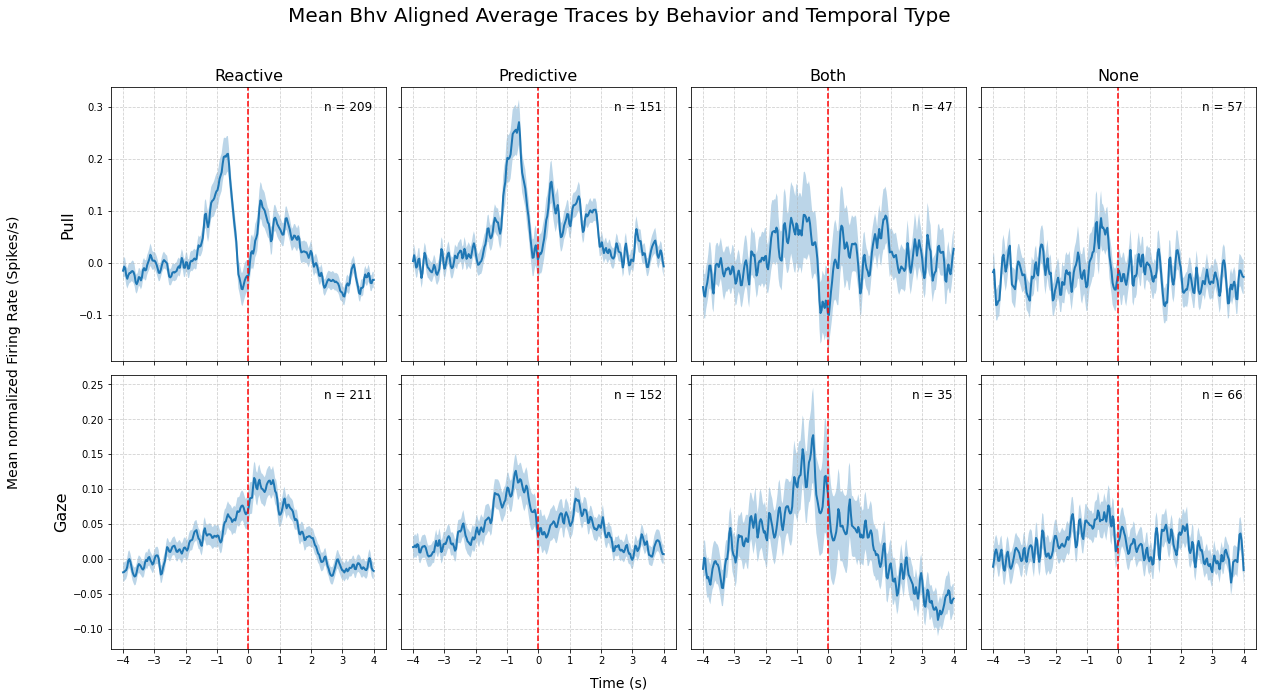

In [172]:
if 1:
    bhv_aligned_FR_trace_tgt = bhv_aligned_FR_trace_summary[np.isin(bhv_aligned_FR_trace_summary['condition'],conditions_to_ana)]

    bhv_aligned_FR_trace_tgt['unique_neuron'] = bhv_aligned_FR_trace_tgt['dates'].astype(str) + '_' + bhv_aligned_FR_trace_tgt['neuronID'].astype(str)
    
    # --- Data Preparation ---
    # The 'SpikeTrigAverage' column is a string representation of a list.
    # We need to convert it into an actual list of numbers (or a numpy array).
    # We use pd.eval to safely evaluate the string as a Python expression.
    # spike_trig_trace_tgt['SpikeTrigAverage'] = spike_trig_trace_tgt['SpikeTrigAverage'].apply(pd.eval).apply(np.array)


    # --- Define Plotting Categories and Behaviors ---
    # We directly use the values from the 'signiTemporalType' column.
    categories = ['Reactive', 'Predictive', 'Both', 'None']
    ncats = np.shape(categories)[0]
    # behaviors = ['pull', 'gaze', 'juice', 'partnerPC1']
    behaviors = ['pull', 'gaze']
    nbhvs = np.shape(behaviors)[0]
    
    # --- Plotting ---
    fig, axes = plt.subplots(nbhvs, ncats, figsize=(5*ncats, 5*nbhvs), sharex=True, sharey='row')
    fig.suptitle('Mean Bhv Aligned Average Traces by Behavior and Temporal Type', fontsize=20)

    for i, bhv in enumerate(behaviors):
        for j, cat_name in enumerate(categories):
            ax = axes[i, j]

            # Filter the data for the current behavior and temporal type category
            df_subset = bhv_aligned_FR_trace_tgt[
                (bhv_aligned_FR_trace_tgt['bhv_name'] == bhv) &
                (bhv_aligned_FR_trace_tgt['signiTemporalType'] == cat_name)
            ]

            # Get the number of unique neurons in this subset
            num_neurons = df_subset['unique_neuron'].nunique()

            if not df_subset.empty:
                # Stack the traces into a 2D numpy array
                all_traces = np.vstack(df_subset['BhvTrigAverage'].values)

                # Calculate mean trace
                mean_trace = np.mean(all_traces, axis=0)

                # Create the time axis from -4s to 4s
                num_points = len(mean_trace)
                time_axis = np.linspace(-4, 4, num=num_points)

                # Plot the mean trace
                ax.plot(time_axis, mean_trace, lw=2, label=f'{bhv} - {cat_name}')

                # Calculate and plot the error area (SEM) if there's more than one neuron
                if num_neurons > 1:
                    sem_trace = np.std(all_traces, axis=0) / np.sqrt(num_neurons)
                    ax.fill_between(time_axis, 
                                    mean_trace - sem_trace, 
                                    mean_trace + sem_trace, 
                                    alpha=0.3)

            # Add the neuron count as text in the top right corner
            ax.text(0.95, 0.95, f'n = {num_neurons}',
                    transform=ax.transAxes,
                    fontsize=12,
                    verticalalignment='top',
                    horizontalalignment='right')

            # Set titles for the columns on the first row
            if i == 0:
                ax.set_title(cat_name, fontsize=16)

            # Set y-axis labels for the rows on the first column
            if j == 0:
                ax.set_ylabel(bhv.capitalize(), fontsize=16)

            ax.grid(True, linestyle='--', alpha=0.6)
            # Add a vertical line for event onset at t=0
            ax.axvline(x=0, color='r', linestyle='--')


    # Set common labels
    fig.text(0.5, 0.04, 'Time (s)', ha='center', va='center', fontsize=14)
    fig.text(0.08, 0.5, 'Mean normalized Firing Rate (Spikes/s)', ha='center', va='center', rotation='vertical', fontsize=14)

    plt.tight_layout(rect=[0.1, 0.05, 0.95, 0.95]) # Adjust layout to make room for titles

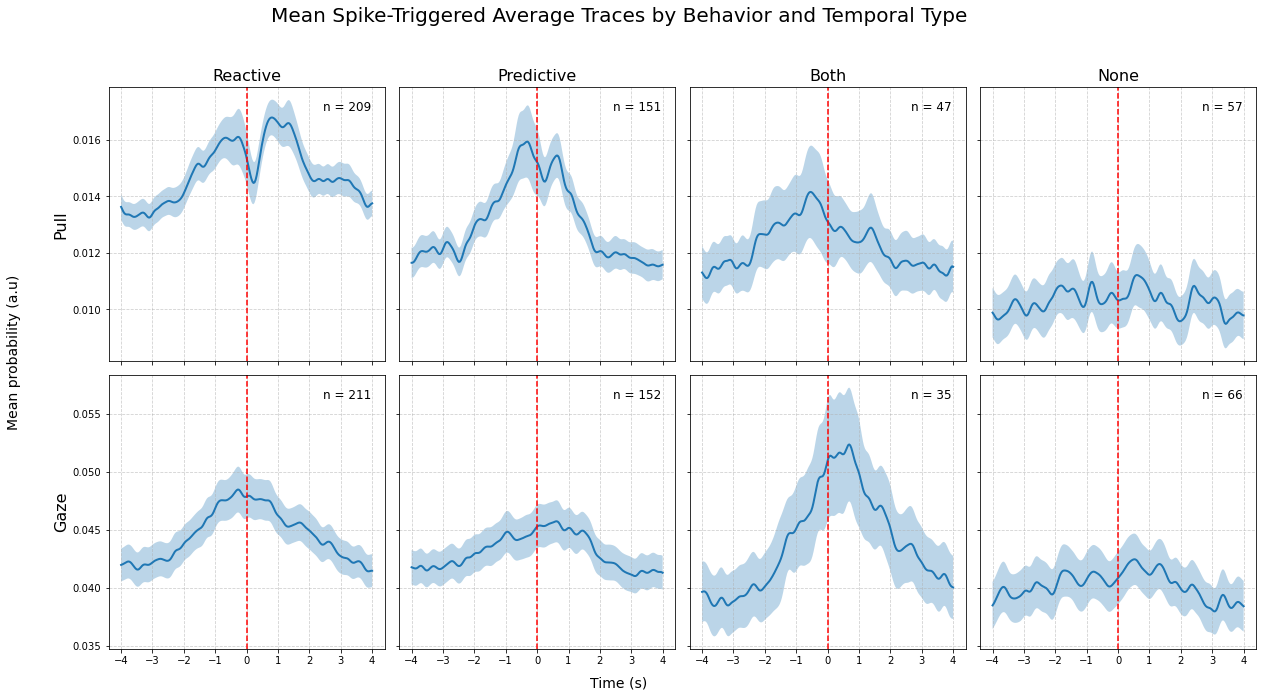

In [173]:
if 1:
    spike_trig_trace_tgt = spike_trig_trace_summary[np.isin(spike_trig_trace_summary['condition'],conditions_to_ana)]

    spike_trig_trace_tgt['unique_neuron'] = spike_trig_trace_tgt['dates'].astype(str) + '_' + spike_trig_trace_tgt['neuronID'].astype(str)
        
    # --- Data Preparation ---
    # The 'SpikeTrigAverage' column is a string representation of a list.
    # We need to convert it into an actual list of numbers (or a numpy array).
    # We use pd.eval to safely evaluate the string as a Python expression.
    # spike_trig_trace_tgt['SpikeTrigAverage'] = spike_trig_trace_tgt['SpikeTrigAverage'].apply(pd.eval).apply(np.array)


    # --- Define Plotting Categories and Behaviors ---
    # We directly use the values from the 'signiTemporalType' column.
    categories = ['Reactive', 'Predictive', 'Both', 'None']
    ncats = np.shape(categories)[0]
    # behaviors = ['pull', 'gaze', 'juice', 'partnerPC1']
    behaviors = ['pull', 'gaze']
    nbhvs = np.shape(behaviors)[0]

    # --- Plotting ---
    fig, axes = plt.subplots(nbhvs, ncats, figsize=(5*ncats, 5*nbhvs), sharex=True, sharey='row')
    fig.suptitle('Mean Spike-Triggered Average Traces by Behavior and Temporal Type', fontsize=20)

    for i, bhv in enumerate(behaviors):
        for j, cat_name in enumerate(categories):
            ax = axes[i, j]

            # Filter the data for the current behavior and temporal type category
            df_subset = spike_trig_trace_tgt[
                (spike_trig_trace_tgt['bhv_name'] == bhv) &
                (spike_trig_trace_tgt['signiTemporalType'] == cat_name)
            ]

            # Get the number of unique neurons in this subset
            num_neurons = df_subset['unique_neuron'].nunique()

            if not df_subset.empty:
                # Stack the traces into a 2D numpy array
                all_traces = np.vstack(df_subset['SpikeTrigAverage'].values)

                # Calculate mean trace
                mean_trace = np.mean(all_traces, axis=0)

                # Create the time axis from -4s to 4s
                num_points = len(mean_trace)
                time_axis = np.linspace(-4, 4, num=num_points)

                # Plot the mean trace
                ax.plot(time_axis, mean_trace, lw=2, label=f'{bhv} - {cat_name}')

                # Calculate and plot the error area (SEM) if there's more than one neuron
                if num_neurons > 1:
                    sem_trace = np.std(all_traces, axis=0) / np.sqrt(num_neurons)
                    ax.fill_between(time_axis, 
                                    mean_trace - sem_trace, 
                                    mean_trace + sem_trace, 
                                    alpha=0.3)

            # Add the neuron count as text in the top right corner
            ax.text(0.95, 0.95, f'n = {num_neurons}',
                    transform=ax.transAxes,
                    fontsize=12,
                    verticalalignment='top',
                    horizontalalignment='right')

            # Set titles for the columns on the first row
            if i == 0:
                ax.set_title(cat_name, fontsize=16)

            # Set y-axis labels for the rows on the first column
            if j == 0:
                ax.set_ylabel(bhv.capitalize(), fontsize=16)

            ax.grid(True, linestyle='--', alpha=0.6)
            # Add a vertical line for event onset at t=0
            ax.axvline(x=0, color='r', linestyle='--')


    # Set common labels
    fig.text(0.5, 0.04, 'Time (s)', ha='center', va='center', fontsize=14)
    fig.text(0.08, 0.5, 'Mean probability (a.u)', ha='center', va='center', rotation='vertical', fontsize=14)

    plt.tight_layout(rect=[0.1, 0.05, 0.95, 0.95]) # Adjust layout to make room for titles

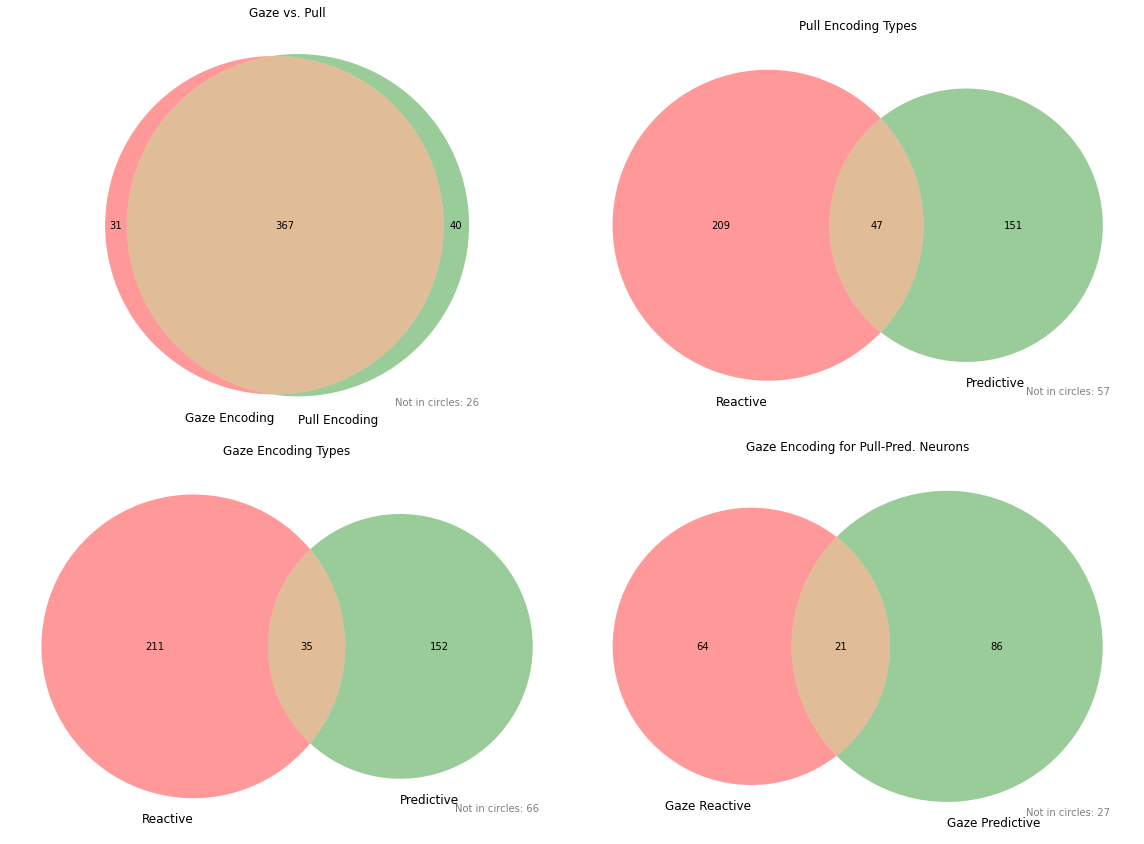

In [174]:
# venn diagram of neuron number catergory
if 1:
    from matplotlib_venn import venn2, venn3

    
    bhv_aligned_FR_trace_tgt = bhv_aligned_FR_trace_summary[np.isin(bhv_aligned_FR_trace_summary['condition'],conditions_to_ana)]

    # Combine 'dates' and 'neuronID' to create a unique identifier for each neuron.
    # This assumes that the combination of these two columns is unique for each neuron.
    bhv_aligned_FR_trace_tgt['unique_neuron'] = bhv_aligned_FR_trace_tgt['dates'].astype(str) + '_' + bhv_aligned_FR_trace_tgt['neuronID'].astype(str)
    total_unique_neurons = bhv_aligned_FR_trace_tgt['unique_neuron'].nunique()

    # Set up the figure for the four subplots
    fig, axs = plt.subplots(2, 2, figsize=(16, 12))
    axs = axs.flatten()

    # --- First Venn Diagram: Gaze vs. Pull ---
    df_encoded = bhv_aligned_FR_trace_tgt[bhv_aligned_FR_trace_tgt['signiTemporalType'] != 'None']
    gaze_neurons = set(df_encoded[df_encoded['bhv_name'] == 'gaze']['unique_neuron'])
    pull_neurons = set(df_encoded[df_encoded['bhv_name'] == 'pull']['unique_neuron'])
    gaze_only = len(gaze_neurons - pull_neurons)
    pull_only = len(pull_neurons - gaze_neurons)
    both_gaze_pull = len(gaze_neurons.intersection(pull_neurons))
    total_in_venn1 = gaze_only + pull_only + both_gaze_pull
    not_in_venn1 = total_unique_neurons - total_in_venn1
    venn2(subsets=(gaze_only, pull_only, both_gaze_pull), set_labels=('Gaze Encoding', 'Pull Encoding'), ax=axs[0])
    axs[0].set_title('Gaze vs. Pull')
    # Add the 'not in circles' count inside the plot area
    axs[0].text(0.95, 0.05, f"Not in circles: {not_in_venn1}", transform=axs[0].transAxes, ha='right', va='bottom', fontsize=10, color='gray')


    # --- Second Venn Diagram: Pull Encoding Types (Swapped) ---
    pull_df = bhv_aligned_FR_trace_tgt[bhv_aligned_FR_trace_tgt['bhv_name'] == 'pull']
    pull_predictive_neurons = set(pull_df[pull_df['signiTemporalType'].isin(['Predictive', 'Both'])]['unique_neuron'])
    pull_reactive_neurons = set(pull_df[pull_df['signiTemporalType'].isin(['Reactive', 'Both'])]['unique_neuron'])
    pull_predictive_only = len(pull_predictive_neurons - pull_reactive_neurons)
    pull_reactive_only = len(pull_reactive_neurons - pull_predictive_neurons)
    pull_both = len(pull_predictive_neurons.intersection(pull_reactive_neurons))
    total_pull_neurons = len(set(pull_df['unique_neuron']))
    total_in_venn2 = pull_predictive_only + pull_reactive_only + pull_both
    not_in_venn2 = total_pull_neurons - total_in_venn2
    venn2(subsets=(pull_reactive_only, pull_predictive_only, pull_both), set_labels=('Reactive', 'Predictive'), ax=axs[1])
    axs[1].set_title('Pull Encoding Types')
    # Add the 'not in circles' count inside the plot area
    axs[1].text(0.95, 0.05, f"Not in circles: {not_in_venn2}", transform=axs[1].transAxes, ha='right', va='bottom', fontsize=10, color='gray')


    # --- Third Venn Diagram: Gaze Encoding Types (Swapped) ---
    gaze_df = bhv_aligned_FR_trace_tgt[bhv_aligned_FR_trace_tgt['bhv_name'] == 'gaze']
    gaze_predictive_neurons = set(gaze_df[gaze_df['signiTemporalType'].isin(['Predictive', 'Both'])]['unique_neuron'])
    gaze_reactive_neurons = set(gaze_df[gaze_df['signiTemporalType'].isin(['Reactive', 'Both'])]['unique_neuron'])
    gaze_predictive_only = len(gaze_predictive_neurons - gaze_reactive_neurons)
    gaze_reactive_only = len(gaze_reactive_neurons - gaze_predictive_neurons)
    gaze_both = len(gaze_predictive_neurons.intersection(gaze_reactive_neurons))
    total_gaze_neurons = len(set(gaze_df['unique_neuron']))
    total_in_venn3 = gaze_predictive_only + gaze_reactive_only + gaze_both
    not_in_venn3 = total_gaze_neurons - total_in_venn3
    venn2(subsets=(gaze_reactive_only, gaze_predictive_only, gaze_both), set_labels=('Reactive', 'Predictive'), ax=axs[2])
    axs[2].set_title('Gaze Encoding Types')
    # Add the 'not in circles' count inside the plot area
    axs[2].text(0.95, 0.05, f"Not in circles: {not_in_venn3}", transform=axs[2].transAxes, ha='right', va='bottom', fontsize=10, color='gray')


    # --- Fourth Venn Diagram: Gaze Encoding for Pull-Predictive Neurons (Swapped) ---
    pull_pred_both_neurons_set = set(bhv_aligned_FR_trace_tgt[
        (bhv_aligned_FR_trace_tgt['bhv_name'] == 'pull') &
        (bhv_aligned_FR_trace_tgt['signiTemporalType'].isin(['Predictive', 'Both']))
    ]['unique_neuron'])

    if not pull_pred_both_neurons_set:
        print("No neurons found with 'Predictive' or 'Both' pull encoding.")
    else:
        subset_df = bhv_aligned_FR_trace_tgt[bhv_aligned_FR_trace_tgt['unique_neuron'].isin(pull_pred_both_neurons_set)]
        gaze_df_in_subset = subset_df[subset_df['bhv_name'] == 'gaze']

        gaze_predictive_neurons_subset = set(gaze_df_in_subset[gaze_df_in_subset['signiTemporalType'].isin(['Predictive', 'Both'])]['unique_neuron'])
        gaze_reactive_neurons_subset = set(gaze_df_in_subset[gaze_df_in_subset['signiTemporalType'].isin(['Reactive', 'Both'])]['unique_neuron'])

        gaze_predictive_only_subset = len(gaze_predictive_neurons_subset - gaze_reactive_neurons_subset)
        gaze_reactive_only_subset = len(gaze_reactive_neurons_subset - gaze_predictive_neurons_subset)
        gaze_both_subset = len(gaze_predictive_neurons_subset.intersection(gaze_reactive_neurons_subset))

        total_in_venn4 = gaze_predictive_only_subset + gaze_reactive_only_subset + gaze_both_subset
        not_in_venn4 = len(pull_pred_both_neurons_set) - total_in_venn4

        venn2(subsets=(gaze_reactive_only_subset, gaze_predictive_only_subset, gaze_both_subset), 
              set_labels=('Gaze Reactive', 'Gaze Predictive'), ax=axs[3])
        axs[3].set_title('Gaze Encoding for Pull-Pred. Neurons')
        # Add the 'not in circles' count inside the plot area
        axs[3].text(0.95, 0.05, f"Not in circles: {not_in_venn4}", transform=axs[3].transAxes, ha='right', va='bottom', fontsize=10, color='gray')


    plt.tight_layout()

    savefig = 1
    if savefig:
        figsavefolder = data_saved_folder+"fig_for_basic_neural_analysis_allsessions_basicEvents_neuralGLMfitting_BasisKernelsForContVaris_singlecam/"+\
                        cameraID+"/"+recordedanimals[0]+"_neuralGLM/"

        if not os.path.exists(figsavefolder):
            os.makedirs(figsavefolder)

        fig.savefig(figsavefolder+recordedanimals[0]+'_NeuronEncoding_PullOrGaze_VennGram_'+glm_encoding_type+savefile_sufix+'_'+cond_toplot_type+'.pdf')
        
    

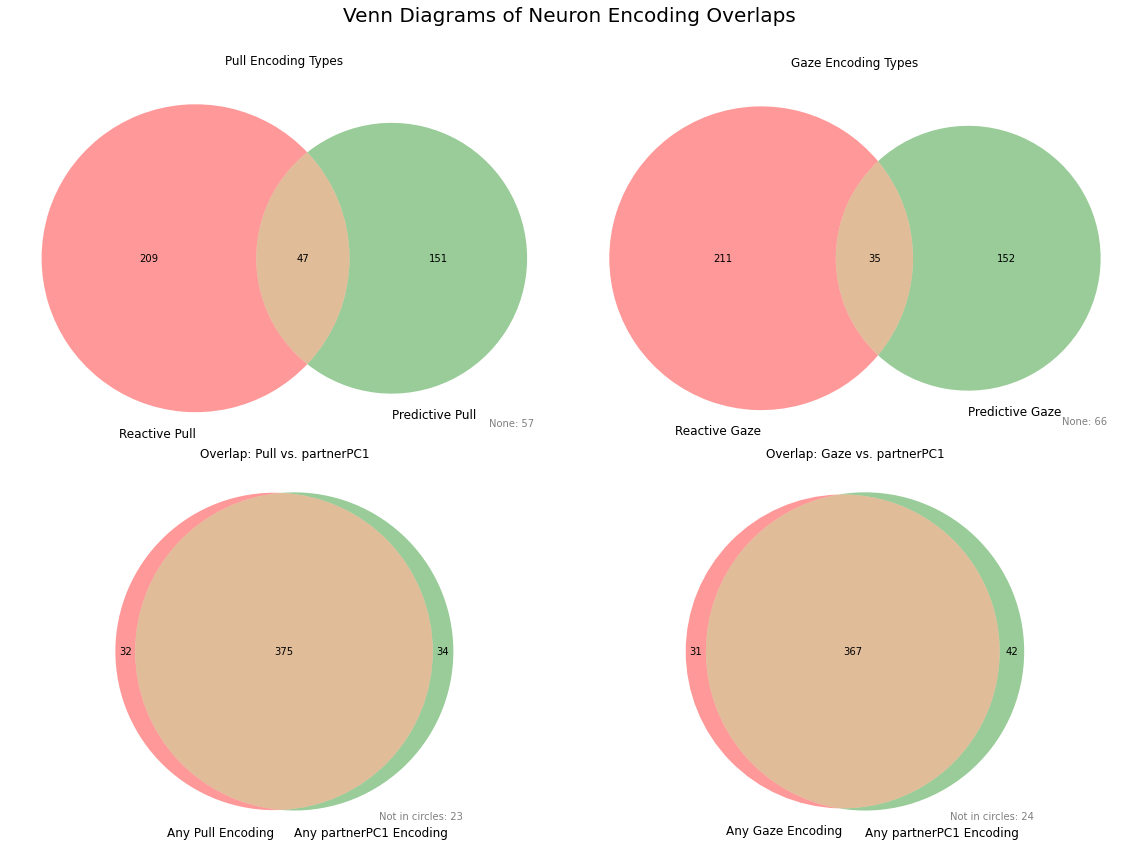

In [175]:
# venn diagram of neuron number catergory
if 1:
    from matplotlib_venn import venn2
    
    bhv_aligned_FR_trace_tgt = bhv_aligned_FR_trace_summary[np.isin(bhv_aligned_FR_trace_summary['condition'],conditions_to_ana)]

    # Create a unique identifier for each neuron to handle data from different dates
    bhv_aligned_FR_trace_tgt['unique_neuron'] = bhv_aligned_FR_trace_tgt['dates'].astype(str) + '_' + bhv_aligned_FR_trace_tgt['neuronID'].astype(str)
    total_unique_neurons = bhv_aligned_FR_trace_tgt['unique_neuron'].nunique()

    # Set up the figure for the four subplots
    fig, axs = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Venn Diagrams of Neuron Encoding Overlaps', fontsize=20)
    axs = axs.flatten()


    # --- 1. Pull Encoding Types (Reactive vs. Predictive) ---
    pull_df = bhv_aligned_FR_trace_tgt[bhv_aligned_FR_trace_tgt['bhv_name'] == 'pull']
    # Neurons that are 'Reactive' or 'Both'
    pull_reactive_neurons = set(pull_df[pull_df['signiTemporalType'].isin(['Reactive', 'Both'])]['unique_neuron'])
    # Neurons that are 'Predictive' or 'Both'
    pull_predictive_neurons = set(pull_df[pull_df['signiTemporalType'].isin(['Predictive', 'Both'])]['unique_neuron'])

    venn2(
        subsets=[pull_reactive_neurons, pull_predictive_neurons],
        set_labels=('Reactive Pull', 'Predictive Pull'),
        ax=axs[0]
    )
    axs[0].set_title('Pull Encoding Types')
    # Calculate and add the 'None' count
    total_pull_neurons = len(set(pull_df['unique_neuron']))
    total_in_venn1 = len(pull_reactive_neurons.union(pull_predictive_neurons))
    not_in_venn1 = total_pull_neurons - total_in_venn1
    axs[0].text(0.95, 0.05, f"None: {not_in_venn1}", transform=axs[0].transAxes, ha='right', va='bottom', fontsize=10, color='gray')


    # --- 2. Gaze Encoding Types (Reactive vs. Predictive) ---
    gaze_df = bhv_aligned_FR_trace_tgt[bhv_aligned_FR_trace_tgt['bhv_name'] == 'gaze']
    # Neurons that are 'Reactive' or 'Both'
    gaze_reactive_neurons = set(gaze_df[gaze_df['signiTemporalType'].isin(['Reactive', 'Both'])]['unique_neuron'])
    # Neurons that are 'Predictive' or 'Both'
    gaze_predictive_neurons = set(gaze_df[gaze_df['signiTemporalType'].isin(['Predictive', 'Both'])]['unique_neuron'])

    venn2(
        subsets=[gaze_reactive_neurons, gaze_predictive_neurons],
        set_labels=('Reactive Gaze', 'Predictive Gaze'),
        ax=axs[1]
    )
    axs[1].set_title('Gaze Encoding Types')
    # Calculate and add the 'None' count
    total_gaze_neurons = len(set(gaze_df['unique_neuron']))
    total_in_venn2 = len(gaze_reactive_neurons.union(gaze_predictive_neurons))
    not_in_venn2 = total_gaze_neurons - total_in_venn2
    axs[1].text(0.95, 0.05, f"None: {not_in_venn2}", transform=axs[1].transAxes, ha='right', va='bottom', fontsize=10, color='gray')


    # --- 3. Overlap: Any Pull Encoding vs. Any partnerPC1 Encoding ---
    # Filter for neurons with any significant encoding type ('None' is excluded)
    df_encoded = bhv_aligned_FR_trace_tgt[bhv_aligned_FR_trace_tgt['signiTemporalType'] != 'None']

    # Get unique neurons for each behavior type
    any_pull_neurons = set(df_encoded[df_encoded['bhv_name'] == 'pull']['unique_neuron'])
    any_partnerPC1_neurons = set(df_encoded[df_encoded['bhv_name'] == 'partnerPC1']['unique_neuron'])

    venn2(
        subsets=[any_pull_neurons, any_partnerPC1_neurons],
        set_labels=('Any Pull Encoding', 'Any partnerPC1 Encoding'),
        ax=axs[2]
    )
    axs[2].set_title('Overlap: Pull vs. partnerPC1')
    # Calculate and add the 'not in circles' count relative to all unique neurons
    total_in_venn3 = len(any_pull_neurons.union(any_partnerPC1_neurons))
    not_in_venn3 = total_unique_neurons - total_in_venn3
    axs[2].text(0.95, 0.05, f"Not in circles: {not_in_venn3}", transform=axs[2].transAxes, ha='right', va='bottom', fontsize=10, color='gray')


    # --- 4. Overlap: Any Gaze Encoding vs. Any partnerPC1 Encoding ---
    # We can reuse the df_encoded from the previous step
    any_gaze_neurons = set(df_encoded[df_encoded['bhv_name'] == 'gaze']['unique_neuron'])
    # The any_partnerPC1_neurons set is the same as in the previous plot

    venn2(
        subsets=[any_gaze_neurons, any_partnerPC1_neurons],
        set_labels=('Any Gaze Encoding', 'Any partnerPC1 Encoding'),
        ax=axs[3]
    )
    axs[3].set_title('Overlap: Gaze vs. partnerPC1')
    # Calculate and add the 'not in circles' count relative to all unique neurons
    total_in_venn4 = len(any_gaze_neurons.union(any_partnerPC1_neurons))
    not_in_venn4 = total_unique_neurons - total_in_venn4
    axs[3].text(0.95, 0.05, f"Not in circles: {not_in_venn4}", transform=axs[3].transAxes, ha='right', va='bottom', fontsize=10, color='gray')


    # --- Final Touches ---
    plt.tight_layout(rect=[0, 0, 1, 0.96]) # Adjust layout to make room for suptitle

    savefig = 0
    if savefig:
        figsavefolder = data_saved_folder+"fig_for_basic_neural_analysis_allsessions_basicEvents_neuralGLMfitting_BasisKernelsForContVaris_singlecam/"+\
                        cameraID+"/"+recordedanimals[0]+"_neuralGLM/"

        if not os.path.exists(figsavefolder):
            os.makedirs(figsavefolder)

        fig.savefig(figsavefolder+recordedanimals[0]+'_NeuronEncoding_PullOrGaze_and_partnerAction_VennGram_'+glm_encoding_type+savefile_sufix+'_'+cond_toplot_type+'.pdf')
        
    

### plot using the loo methods to define the significant neurons 

In [176]:
# from p value, defining significant encoding type considering correction
indices = np.where(np.isin(task_conditions, conditions_to_ana))[0]
dates_to_ana = np.array(dates_list)[indices]

# load targeted pvalues
ind_con_tgt = np.isin(neuralGLM_mainAxes_partnerPC1_LOOmethod_kernels_pvalues_summary['date'],dates_to_ana)
pvalue_tgt = neuralGLM_mainAxes_partnerPC1_LOOmethod_kernels_pvalues_summary[ind_con_tgt]

# load targeted filters
tempFilter_tgt = {
    date: neuralGLM_mainAxes_partnerPC1_LOOmethod_kernels_tempFilter_summary[date]
    for date in dates_to_ana
    if date in neuralGLM_mainAxes_partnerPC1_LOOmethod_kernels_tempFilter_summary}


# Create a unique identifier for each neuron to handle data from different date
pvalue_tgt['unique_neuron'] = pvalue_tgt['date'].astype(str) + '_' + pvalue_tgt['neuronID'].astype(str)

# --- Step 1: Isolate the p-value columns for correction ---
p_value_cols = [
    'var_pull_past', 'var_pull_future', 'var_gaze_past', 'var_gaze_future',
    'var_juice_past', 'var_juice_future', 'partner_PC1_past', 'partner_PC1_future'
]
raw_p_values_df = pvalue_tgt[p_value_cols]


# --- Step 2: Perform the Global FDR Correction ---

# Flatten the DataFrame into a single 1D array.
original_shape = raw_p_values_df.shape
all_p_values = raw_p_values_df.values.flatten()

# The correction function cannot handle NaNs, so we create a mask to track them.
nan_mask = np.isnan(all_p_values)
p_values_for_correction = all_p_values[~nan_mask]

# Apply the Benjamini-Hochberg FDR correction.
is_significant_flat, q_values_flat, _, _ = multipletests(
    p_values_for_correction, 
    alpha=0.05,  # Standard significance level for FDR
    # method='fdr_bh'
    method='bonferroni'
)

# Reshape the corrected q-values back into the original DataFrame shape.
q_values_full = np.full(all_p_values.shape, np.nan)
q_values_full[~nan_mask] = q_values_flat
q_values_reshaped = q_values_full.reshape(original_shape)

# Create a final DataFrame for the q-values with the original index and columns.
q_values_df = pd.DataFrame(q_values_reshaped, index=raw_p_values_df.index, columns=raw_p_values_df.columns)

# This is the fully corrected boolean DataFrame indicating significance (q < 0.05).
significant_results_df = q_values_df < 0.05


# --- Step 3: Classify Encoding Type for ALL Variables ---

# Define a GENERALIZED function to classify based on corrected significance
def classify_encoding(row, base_variable_name):
    """
    Classifies encoding type for a given base variable name.
    Example: base_variable_name = 'var_pull'
    """
    sig_past = row[f'{base_variable_name}_past']
    sig_future = row[f'{base_variable_name}_future']
    
    if sig_past and sig_future:
        return 'Both'
    elif sig_past:
        return 'Reactive'
    elif sig_future:
        return 'Predictive'
    else:
        return 'None'

# Apply the function for each of the four behavioral variables
pull_encoding_type = significant_results_df.apply(lambda row: classify_encoding(row, 'var_pull'), axis=1)
gaze_encoding_type = significant_results_df.apply(lambda row: classify_encoding(row, 'var_gaze'), axis=1)
juice_encoding_type = significant_results_df.apply(lambda row: classify_encoding(row, 'var_juice'), axis=1)
partner_encoding_type = significant_results_df.apply(lambda row: classify_encoding(row, 'partner_PC1'), axis=1)


# --- Step 4: Create the Final, Expanded Summary DataFrame ---

summary_df = pd.DataFrame({
    'unique_neuron': pvalue_tgt['unique_neuron'],
    'pull_encoding': pull_encoding_type,
    'gaze_encoding': gaze_encoding_type,
    'juice_encoding': juice_encoding_type,
    'partner_PC1_encoding': partner_encoding_type
})


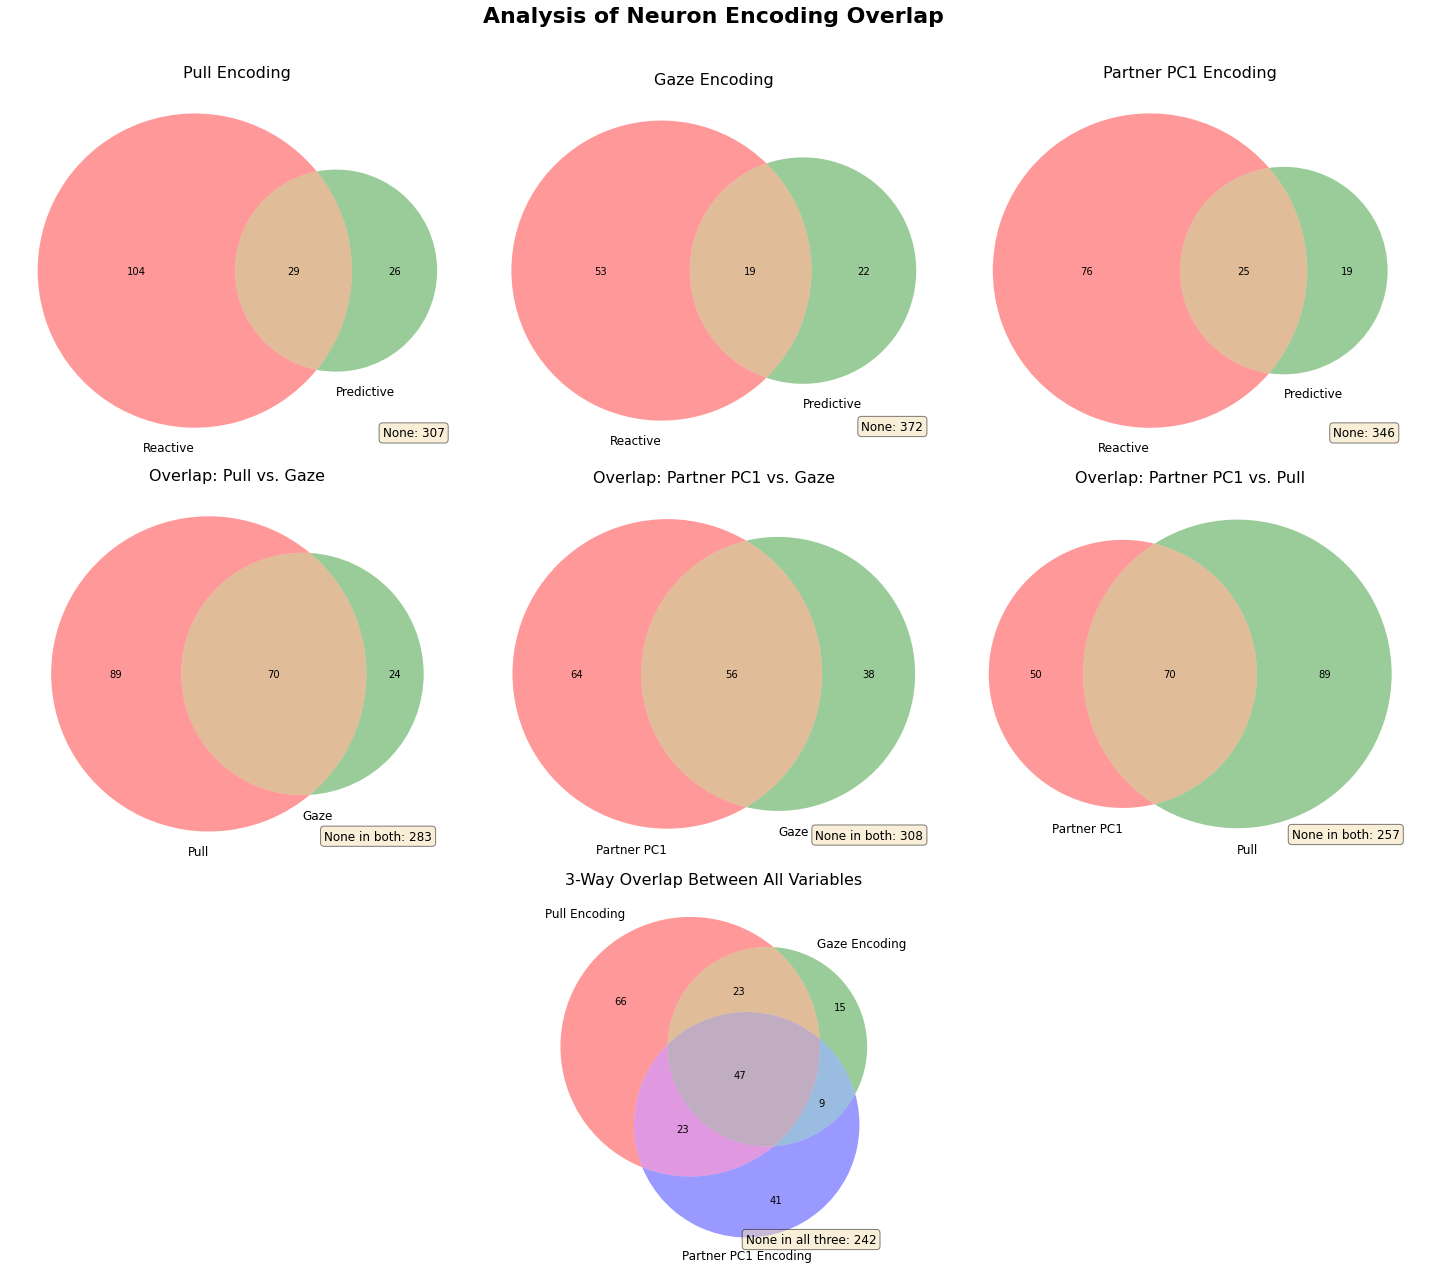

In [177]:
# venn diagram
if 1:

    from matplotlib_venn import venn2, venn3

    # --- Create a single figure to hold all plots ---
    fig = plt.figure(figsize=(20, 18))
    fig.suptitle('Analysis of Neuron Encoding Overlap', fontsize=22, fontweight='bold')

    # --- 1. Venn Diagrams for Reactive vs. Predictive Encoding ---

    # A helper function to create the Reactive/Predictive Venn diagrams
    def plot_encoding_type_venn(ax, df, base_name, title):
        """Creates a Venn diagram for a variable's reactive vs. predictive encoding."""
        reactive_set = set(df[df[f'{base_name}_encoding'].isin(['Reactive', 'Both'])]['unique_neuron'])
        predictive_set = set(df[df[f'{base_name}_encoding'].isin(['Predictive', 'Both'])]['unique_neuron'])

        # Calculate the number of neurons with 'None' encoding for this variable
        none_count = df[df[f'{base_name}_encoding'] == 'None'].shape[0]

        venn2([reactive_set, predictive_set], 
              set_labels=('Reactive', 'Predictive'), 
              ax=ax)
        ax.set_title(title, fontsize=16)

        # Add text annotation for the 'None' count
        ax.text(0.95, 0.05, f"None: {none_count}", 
                transform=ax.transAxes, ha='right', va='bottom',
                fontsize=12, bbox=dict(boxstyle='round,pad=0.3', fc='wheat', alpha=0.5))


    # Create subplots for the first row
    ax1 = plt.subplot2grid((3, 3), (0, 0))
    ax2 = plt.subplot2grid((3, 3), (0, 1))
    ax3 = plt.subplot2grid((3, 3), (0, 2))

    # Generate the plots
    plot_encoding_type_venn(ax1, summary_df, 'pull', 'Pull Encoding')
    plot_encoding_type_venn(ax2, summary_df, 'gaze', 'Gaze Encoding')
    plot_encoding_type_venn(ax3, summary_df, 'partner_PC1', 'Partner PC1 Encoding')


    # --- 2. Venn Diagrams for Overlap Between Variables ---

    # A helper function to get the set of all neurons encoding a variable
    def get_any_encoding_set(df, base_name):
        """Returns the set of neurons with any encoding type other than 'None'."""
        return set(df[df[f'{base_name}_encoding'] != 'None']['unique_neuron'])

    # Get the sets for each main variable
    pull_set = get_any_encoding_set(summary_df, 'pull')
    gaze_set = get_any_encoding_set(summary_df, 'gaze')
    partner_set = get_any_encoding_set(summary_df, 'partner_PC1')

    # Create subplots for the second row
    ax4 = plt.subplot2grid((3, 3), (1, 0))
    ax5 = plt.subplot2grid((3, 3), (1, 1))
    ax6 = plt.subplot2grid((3, 3), (1, 2))

    # Overlap between Pull and Gaze
    none_pull_gaze = summary_df[(summary_df['pull_encoding'] == 'None') & (summary_df['gaze_encoding'] == 'None')].shape[0]
    venn2([pull_set, gaze_set], set_labels=('Pull', 'Gaze'), ax=ax4)
    ax4.set_title('Overlap: Pull vs. Gaze', fontsize=16)
    ax4.text(0.95, 0.05, f"None in both: {none_pull_gaze}",
             transform=ax4.transAxes, ha='right', va='bottom',
             fontsize=12, bbox=dict(boxstyle='round,pad=0.3', fc='wheat', alpha=0.5))

    # Overlap between Partner PC1 and Gaze
    none_partner_gaze = summary_df[(summary_df['partner_PC1_encoding'] == 'None') & (summary_df['gaze_encoding'] == 'None')].shape[0]
    venn2([partner_set, gaze_set], set_labels=('Partner PC1', 'Gaze'), ax=ax5)
    ax5.set_title('Overlap: Partner PC1 vs. Gaze', fontsize=16)
    ax5.text(0.95, 0.05, f"None in both: {none_partner_gaze}",
             transform=ax5.transAxes, ha='right', va='bottom',
             fontsize=12, bbox=dict(boxstyle='round,pad=0.3', fc='wheat', alpha=0.5))

    # Overlap between Partner PC1 and Pull
    none_partner_pull = summary_df[(summary_df['partner_PC1_encoding'] == 'None') & (summary_df['pull_encoding'] == 'None')].shape[0]
    venn2([partner_set, pull_set], set_labels=('Partner PC1', 'Pull'), ax=ax6)
    ax6.set_title('Overlap: Partner PC1 vs. Pull', fontsize=16)
    ax6.text(0.95, 0.05, f"None in both: {none_partner_pull}",
             transform=ax6.transAxes, ha='right', va='bottom',
             fontsize=12, bbox=dict(boxstyle='round,pad=0.3', fc='wheat', alpha=0.5))


    # --- 3. 3-Way Venn Diagram for All Variables ---
    ax7 = plt.subplot2grid((3, 3), (2, 0), colspan=3)
    none_all_three = summary_df[
        (summary_df['pull_encoding'] == 'None') &
        (summary_df['gaze_encoding'] == 'None') &
        (summary_df['partner_PC1_encoding'] == 'None')
    ].shape[0]
    venn3([pull_set, gaze_set, partner_set], set_labels=('Pull Encoding', 'Gaze Encoding', 'Partner PC1 Encoding'), ax=ax7)
    ax7.set_title('3-Way Overlap Between All Variables', fontsize=16)
    ax7.text(0.95, 0.05, f"None in all three: {none_all_three}",
             transform=ax7.transAxes, ha='right', va='bottom',
             fontsize=12, bbox=dict(boxstyle='round,pad=0.3', fc='wheat', alpha=0.5))


    # Adjust layout and display the final figure
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    
    
    
    
    
    savefig = 1
    if savefig:
        figsavefolder = data_saved_folder+"fig_for_basic_neural_analysis_allsessions_basicEvents_neuralGLMfitting_BasisKernelsForContVaris_singlecam/"+\
                        cameraID+"/"+recordedanimals[0]+"_neuralGLM/"

        if not os.path.exists(figsavefolder):
            os.makedirs(figsavefolder)

        fig.savefig(figsavefolder+recordedanimals[0]+'_NeuronEncoding_PullOrGaze_and_partnerAction_VennGram_LOOmethods_'+savefile_sufix+'_'+cond_toplot_type+'.pdf')
        
    


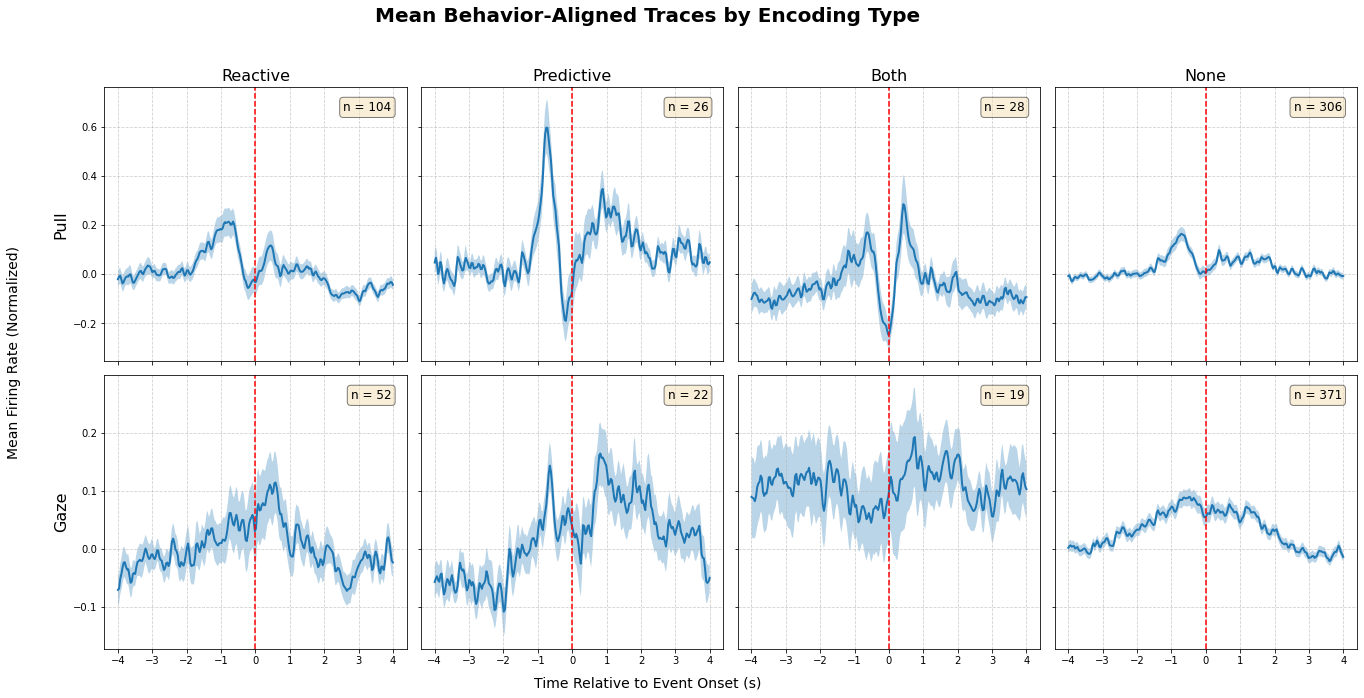

In [178]:
# the firing rate behavioral aligned trace of each types of neurons, defined based on LOO
if 1:
    bhv_aligned_FR_trace_tgt = bhv_aligned_FR_trace_summary[np.isin(bhv_aligned_FR_trace_summary['condition'],conditions_to_ana)]

    bhv_aligned_FR_trace_tgt['unique_neuron'] = bhv_aligned_FR_trace_tgt['dates'].astype(str) + '_' + bhv_aligned_FR_trace_tgt['neuronID'].astype(int).astype(str)

    #  --- 1. Merge Trace Data with Encoding Classifications ---
    # This is the key step: we add the encoding columns (e.g., 'pull_encoding')
    # to the DataFrame that contains the traces.
    merged_df = pd.merge(bhv_aligned_FR_trace_tgt, summary_df, on='unique_neuron')


    # --- 2. Define Plotting Categories and Behaviors ---
    categories = ['Reactive', 'Predictive', 'Both', 'None']
    ncats = len(categories)
    behaviors = ['pull', 'gaze']
    nbhvs = len(behaviors)

    # --- 3. Plotting ---
    fig, axes = plt.subplots(nbhvs, ncats, figsize=(5 * ncats, 5 * nbhvs), sharex=True, sharey='row')
    fig.suptitle('Mean Behavior-Aligned Traces by Encoding Type', fontsize=20, fontweight='bold')

    for i, bhv in enumerate(behaviors):
        for j, cat_name in enumerate(categories):
            ax = axes[i, j]

            # Filter the merged data for the current behavior AND its corresponding encoding type
            # For example, when bhv='pull', we filter using the 'pull_encoding' column.
            encoding_column_name = f'{bhv}_encoding'
            df_subset = merged_df[
                (merged_df['bhv_name'] == bhv) &
                (merged_df[encoding_column_name] == cat_name)
            ]

            # Get the number of unique neurons in this subset
            num_neurons = df_subset['unique_neuron'].nunique()

            if not df_subset.empty:
                # Stack the traces into a 2D numpy array
                all_traces = np.vstack(df_subset['BhvTrigAverage'].values)

                # Calculate mean trace
                mean_trace = np.mean(all_traces, axis=0)

                # Create the time axis from -4s to 4s
                num_points = len(mean_trace)
                time_axis = np.linspace(-4, 4, num=num_points)

                # Plot the mean trace
                ax.plot(time_axis, mean_trace, lw=2)

                # Calculate and plot the error area (SEM) if there's more than one neuron
                if num_neurons > 1:
                    sem_trace = np.std(all_traces, axis=0) / np.sqrt(num_neurons)
                    ax.fill_between(time_axis, 
                                    mean_trace - sem_trace, 
                                    mean_trace + sem_trace, 
                                    alpha=0.3)

            # Add the neuron count as text in the top right corner
            ax.text(0.95, 0.95, f'n = {num_neurons}',
                    transform=ax.transAxes,
                    fontsize=12,
                    verticalalignment='top',
                    horizontalalignment='right',
                    bbox=dict(boxstyle='round,pad=0.3', fc='wheat', alpha=0.5))

            # Set titles for the columns on the first row
            if i == 0:
                ax.set_title(cat_name, fontsize=16)

            # Set y-axis labels for the rows on the first column
            if j == 0:
                ax.set_ylabel(bhv.capitalize(), fontsize=16)

            ax.grid(True, linestyle='--', alpha=0.6)
            # Add a vertical line for event onset at t=0
            ax.axvline(x=0, color='r', linestyle='--')

    # Set common labels
    fig.text(0.5, 0.04, 'Time Relative to Event Onset (s)', ha='center', va='center', fontsize=14)
    fig.text(0.06, 0.5, 'Mean Firing Rate (Normalized)', ha='center', va='center', rotation='vertical', fontsize=14)

    plt.tight_layout(rect=[0.08, 0.05, 1, 0.95]) # Adjust layout
    plt.show()

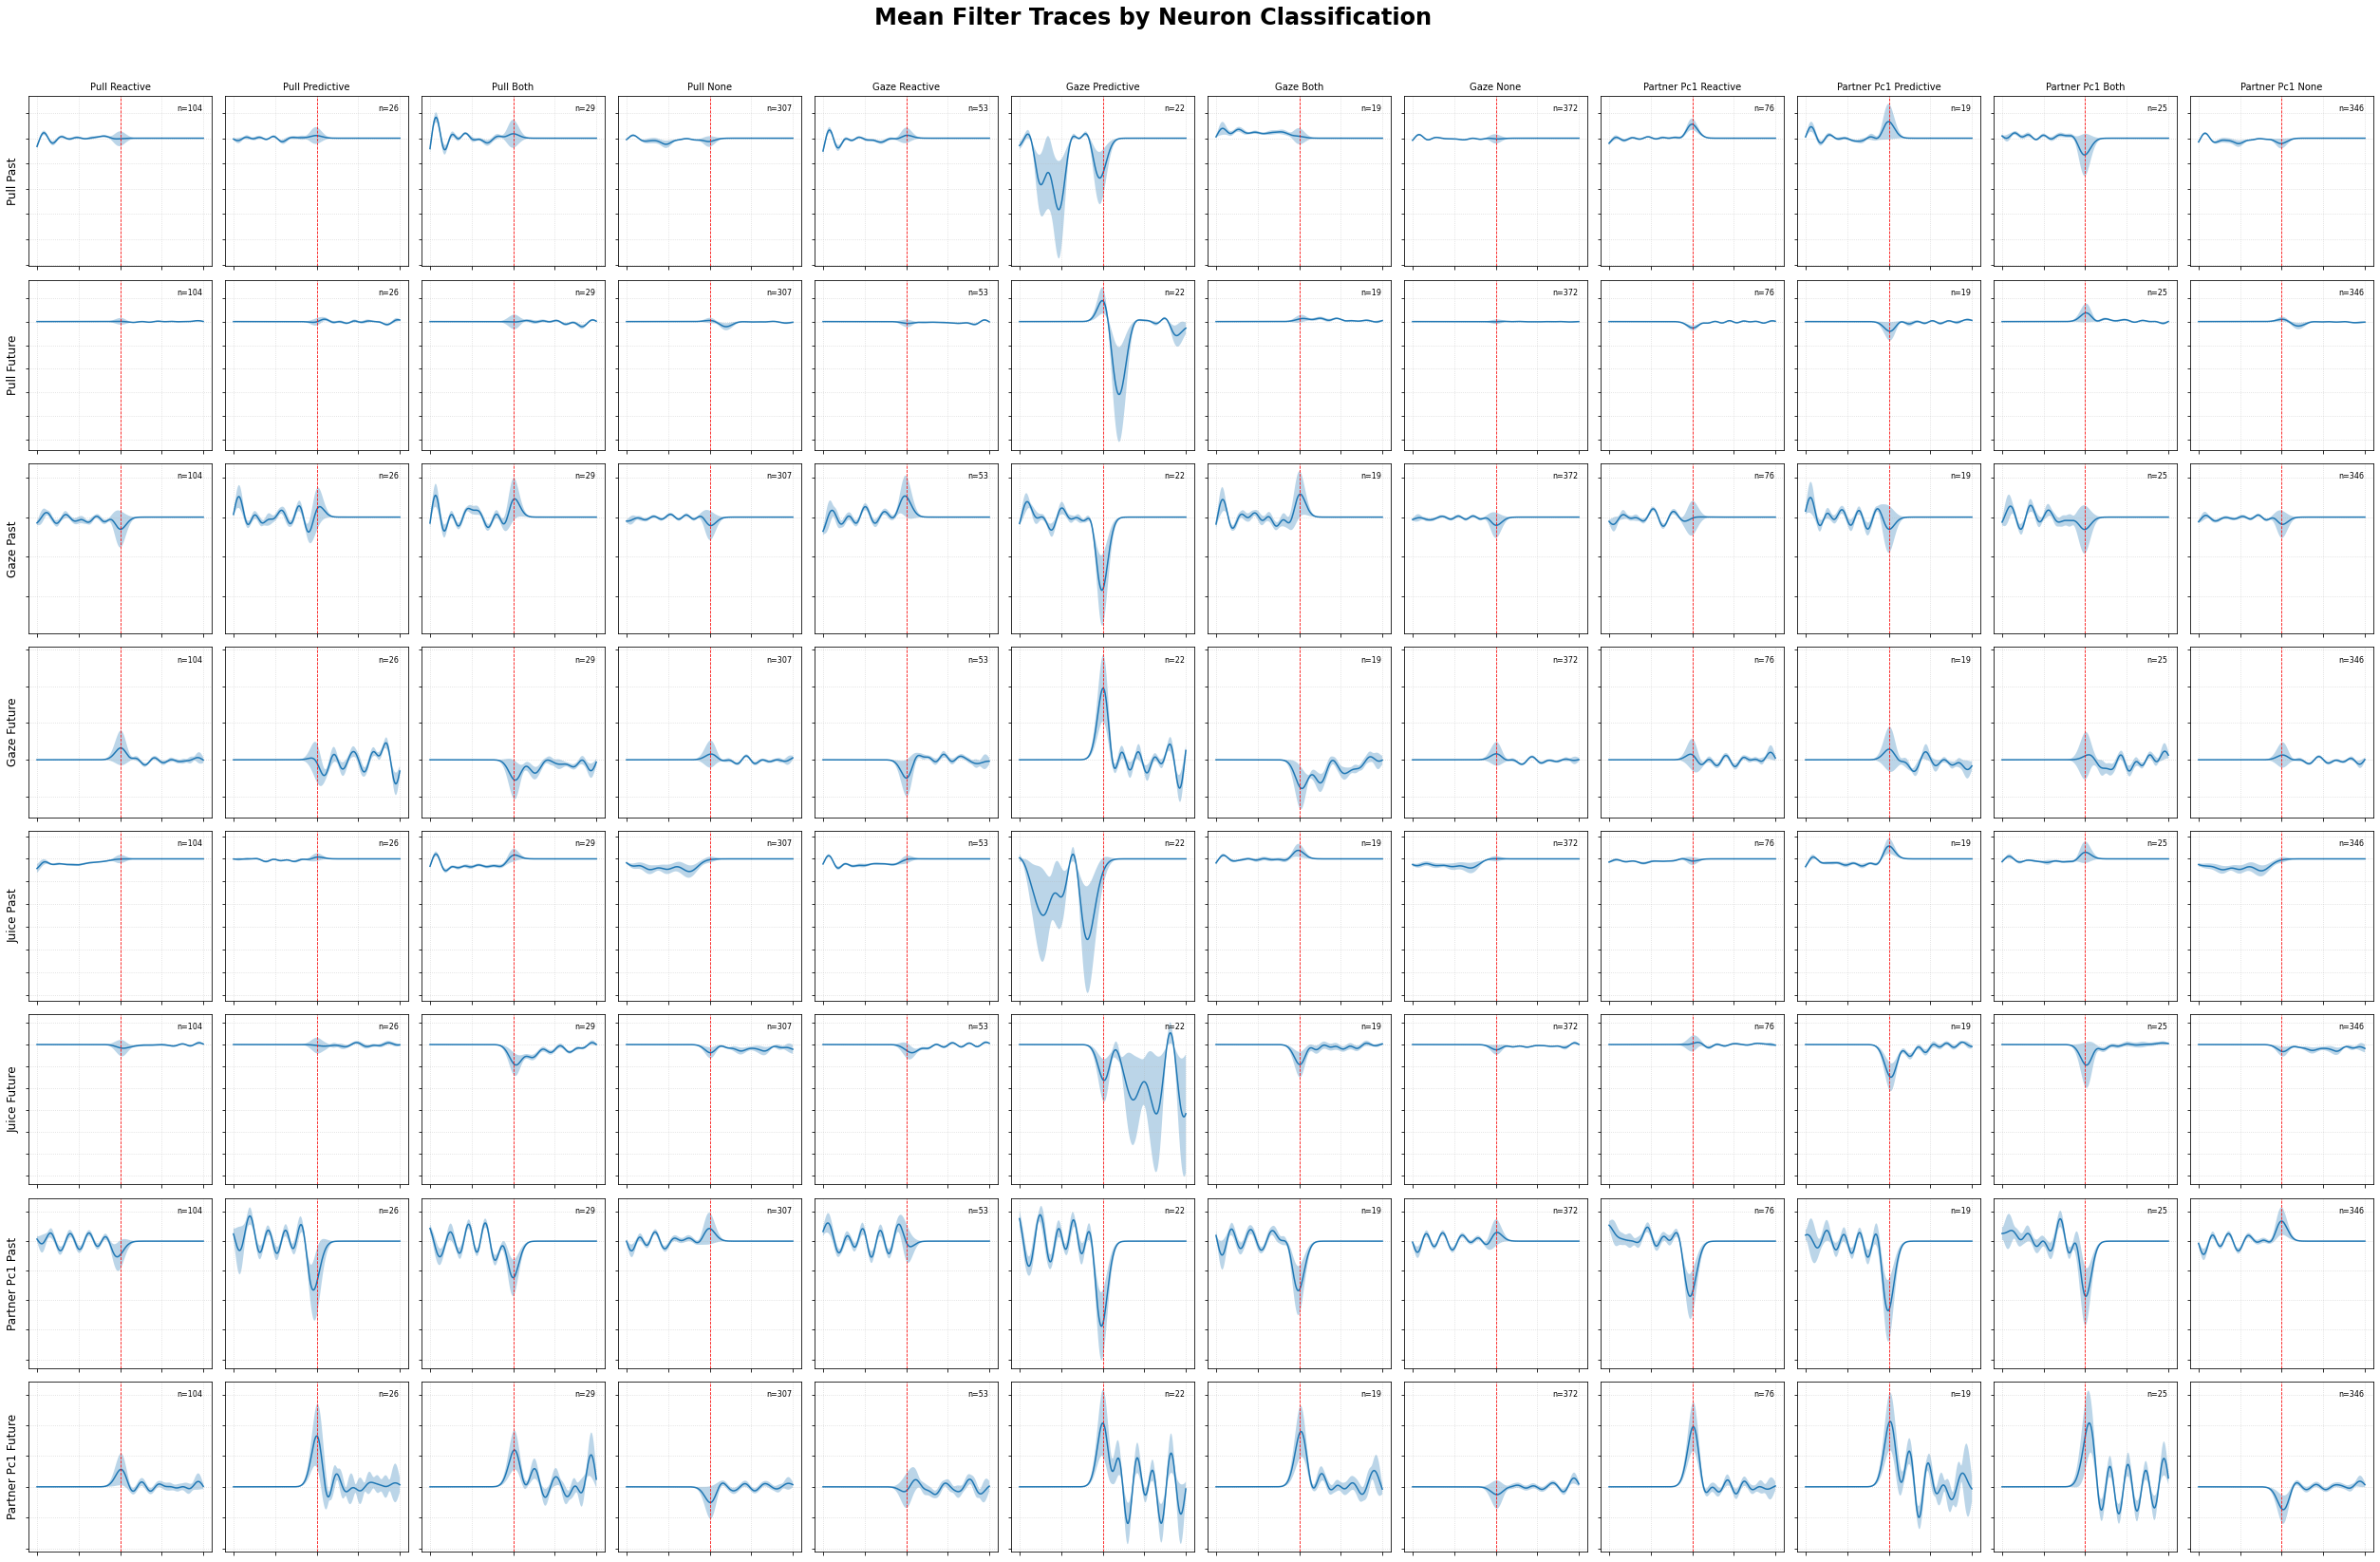

In [179]:
# --- 1. Generate the 8x12 Plot ---
# Define the rows (8 split-variable types) and columns (12 neuron classifications)
base_variables = ['pull', 'gaze', 'juice', 'partner_PC1']
time_types = ['past', 'future']
row_labels = [f'{var}_{ttype}' for var in base_variables for ttype in time_types]

col_vars = ['pull', 'gaze', 'partner_PC1']
col_types = ['Reactive', 'Predictive', 'Both', 'None']
col_labels = [f'{var}_{ctype}' for var in col_vars for ctype in col_types]

fig, axes = plt.subplots(len(row_labels), len(col_labels), figsize=(36, 24), sharex=True, sharey='row')
fig.suptitle('Mean Filter Traces by Neuron Classification', fontsize=24, fontweight='bold')

for i, row_name in enumerate(row_labels):
    for j, col_name in enumerate(col_labels):
        ax = axes[i, j]
        
        # Parse the column name to get the variable and classification type
        col_var, col_type = col_name.rsplit('_', 1)
        
        # Get the list of unique neurons that match the column's classification
        target_neurons = set(summary_df[summary_df[f'{col_var}_encoding'] == col_type]['unique_neuron'])
        
        # For the target neurons, get their specific trace for the current row's variable
        traces_to_average = []
        
        for unique_id in target_neurons:
            try:
                # Parse the unique ID to get date and neuron ID
                last_underscore_idx = unique_id.rfind('_')
                date = unique_id[:last_underscore_idx]
                neuron_id_str = unique_id[last_underscore_idx+1:]
                neuron_id = int(neuron_id_str)
                
                # Parse the row name to get the variable and time type (_past or _future)
                row_var, row_time_type = row_name.rsplit('_', 1)
                
                # Handle inconsistent key names for partner_PC1
                key_prefix = 'var_' if row_var != 'partner_PC1' else ''

                # Retrieve the specific trace ('_past' or '_future') for the current row's variable
                trace_key = f'{key_prefix}{row_var}_{row_time_type}'
                trace = tempFilter_tgt[date][neuron_id][trace_key]
                traces_to_average.append(trace)

            except (KeyError, ValueError):
                continue

        num_neurons = len(traces_to_average)
        
        if num_neurons > 0:
            all_traces = np.vstack(traces_to_average)
            mean_trace = np.mean(all_traces, axis=0)
            
            num_points = len(mean_trace)
            time_axis = np.linspace(-4, 4, num=num_points)
            
            ax.plot(time_axis, mean_trace, lw=1.5)
            
            if num_neurons > 1:
                sem = np.std(all_traces, axis=0) / np.sqrt(num_neurons)
                ax.fill_between(time_axis, mean_trace - sem, mean_trace + sem, alpha=0.3)
        
        # --- Labeling and Formatting ---
        ax.axvline(x=0, color='r', linestyle='--', lw=0.8)
        ax.grid(True, linestyle=':', alpha=0.5)
        
        # Add neuron count
        ax.text(0.95, 0.95, f'n={num_neurons}', transform=ax.transAxes, ha='right', va='top', fontsize=8)

        # Set column titles on the top row
        if i == 0:
            ax.set_title(col_name.replace("_", " ").title(), fontsize=10)
            
        # Set row titles on the first column
        if j == 0:
            ax.set_ylabel(row_name.replace("_", " ").title(), rotation=90, fontsize=12, labelpad=10)

# Hide axis labels for inner plots to clean up the figure
for ax in axes.flat:
    ax.tick_params(labelleft=False, labelbottom=False)

plt.tight_layout(rect=[0.03, 0.03, 1, 0.96])